<a href="https://colab.research.google.com/github/giveyourselfaTRY/phototaxis-pomdp-crn/blob/main/ML_part_biomodel_phototaxis_POMDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive has been mounted to /content/drive")

Mounted at /content/drive
Google Drive has been mounted to /content/drive


# Preprocessing

Ground check with
the alignment of DTI and length of raw trajectory data

In [ ]:
import numpy as np, pandas as pd, io, os

FPS = 7.2
CSV = "/content/drive/MyDrive/Colab_Notebooks/internship/tr_1634_52.csv"
DTI = "/content/drive/MyDrive/Colab_Notebooks/internship/dti.npy"

# read CSV

def read_movie52_space_csv(path):
    with open(path, "r", encoding="utf-8") as f:
        lines = [ln for ln in f.readlines() if not ln.strip().startswith("#")]
    df = pd.read_csv(io.StringIO("".join(lines)), delim_whitespace=True, header=None,
                     names=["frame","x","y","cell_id"])
    df = df.astype({"frame": float, "x": float, "y": float, "cell_id": float})
    df["cell_id"] = df["cell_id"].astype(int)
    return df

def inspect_frames_and_dti(df, dti=None):
    gmin, gmax = int(df["frame"].min()), int(df["frame"].max())
    nunq = int(df["frame"].nunique())
    print(f"[GLOBAL] frame_min={gmin}, frame_max={gmax}, unique_frames={nunq}")

    if dti is not None:
        dti = np.asarray(dti, float)
        print(f"[DTI] len={len(dti)}  mean={dti.mean():.5f}  std={dti.std():.5f}  "
              f"min={dti.min():.5f}  max={dti.max():.5f}")
        uniform_dt = 1.0/FPS
        dev = np.abs(dti - uniform_dt)
        print(f"[DTI] median|dti-1/fps|={np.median(dev):.5f}  p95={np.percentile(dev,95):.5f}  "
              f"CV={dti.std()/(dti.mean()+1e-12):.4f}")
        exp_len = gmax - gmin
        print(f"[CONSISTENCY] expected_len≈frame_range={exp_len}  match? {abs(len(dti)-exp_len)<=1}")

    # each trajectory
    rows=[]
    for cid, g in df.sort_values(["cell_id","frame"]).groupby("cell_id"):
        fmin, fmax = int(g["frame"].min()), int(g["frame"].max())
        n = len(g)
        nunq = g["frame"].nunique()
        rows.append(dict(cell_id=int(cid), frames=n, unique_frames=int(nunq),
                         frame_min=fmin, frame_max=fmax))
    info = pd.DataFrame(rows).sort_values("cell_id")
    print("\n[PER-CELL] head():")
    display(info.head())
    print(f"[PER-CELL] cells={len(info)}, number of frames per cell: mean={info['frames'].mean():.1f}, "
          f"min={info['frames'].min()}, max={info['frames'].max()}")
    print(f"[PER-CELL] unique frames per cell: mean={info['unique_frames'].mean():.1f}, "
          f"min={info['unique_frames'].min()}, max={info['unique_frames'].max()}")


    return info



In [ ]:
df  = read_movie52_space_csv(CSV)
dti = np.load(DTI, allow_pickle=True).astype(float)
inspect_frames_and_dti(df, dti)


/tmp/ipython-input-3300889248.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(io.StringIO("".join(lines)), delim_whitespace=True, header=None,


[GLOBAL] frame_min=64, frame_max=2292, unique_frames=2224
[DTI] len=2260  mean=0.15875  std=0.04975  min=0.07000  max=0.25000
[DTI] median|dti-1/fps|=0.00889  p95=0.11111  CV=0.3134
[CONSISTENCY] expected_len≈frame_range=2228  match? False

[PER-CELL] head():


,cell_id,frames,unique_frames,frame_min,frame_max
0,0,554,554,64,617
1,1,534,534,85,618
2,2,797,797,707,1503
3,3,546,546,652,1197
4,4,527,527,664,1190


[PER-CELL] cells=30, number of frames per cell: mean=586.8, min=502, max=797
[PER-CELL] unique frames per cell: mean=586.8, min=502, max=797


,cell_id,frames,unique_frames,frame_min,frame_max
0,0,554,554,64,617
1,1,534,534,85,618
2,2,797,797,707,1503
3,3,546,546,652,1197
4,4,527,527,664,1190
5,5,772,772,465,1236
6,6,794,794,707,1500
7,7,504,504,747,1250
8,8,530,530,784,1313
9,9,560,560,873,1432


No trajectory info between frame 1504 to 1508, which is why

```
unique_frame is not frame_max-frame_min
```

We also observe that

```
len(dti)=2260> frame_range=2228
```
And the data in dti is not uniform



In [ ]:
np.load(DTI)

array([0.13, 0.13, 0.13, ..., 0.25, 0.19, 0.07])

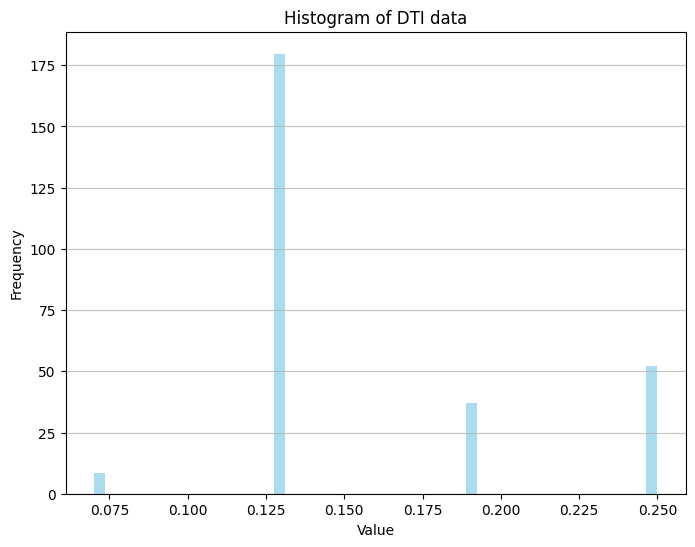

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

plt.hist(dti, bins=50, density=True, alpha=0.7, color='skyblue')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of DTI data")
plt.grid(axis='y', alpha=0.75)
plt.show()

So we will just use part of the timestamps according to the length of each trajectory


---

## Mapping DTI to frame-level time intervals

Let the movie frames span integers $(f\in{f_{\min},\ldots,f_{\max}}).$
The DTI file provides **inter-frame intervals** $(\Delta t_k)$ for $(k=0,\ldots, L-1),$ where
$$
L = f_{\max}-f_{\min},\qquad
\Delta t_k \text{ corresponds to } (f_{\min}+k)\to(f_{\min}+k+1).
$$
We build a **global absolute time axis** by cumulative sum:
$$
T(0)=0,\qquad
T(k)=\sum_{j=0}^{k-1}\Delta t_j\quad (k\ge1).
$$
For any frame $(f)$, the absolute time is looked up by
$$
t_{\text{abs}}(f)=T\big(f-f_{\min}\big).
$$

> This automatically handles **missing frames**: if a trajectory jumps from $f_0$ to $f_{I}>f_0+1$, then
> $(t_{\text{abs}}(f_{I})-t_{\text{abs}}(f_0)=\sum_{k=f_0}^{f_{I}-1}\Delta t_k).$

In code (`_build_time_lookup_from_dti`), `cum_t = [0, cumsum(DTI)]` implements $T(\cdot)$.

## Per-trajectory preprocessing( time, velocity and heading )

For a trajectory $c$, let its ordered frames be $\{f_i^c\}_{i=0}^{n_c-1}$ with positions $(x_i^c,y_i^c)$.

* **Relative time** (per trajectory):
  $$
  t_i^c = t_{\text{abs}}(f_i^c);-;t_{\text{abs}}(f_0^c).
  $$
* **Time step**:
  $$
  \Delta t_i^c =
  \begin{cases}
  0, & i=0,\
  t_{\text{abs}}(f_i^c)-t_{\text{abs}}(f_{i-1}^c), & i\ge1.
  \end{cases}
  $$
* **Displacements**:
  $$
  \Delta x_i^c = x_i^c - x_{i-1}^c,\qquad
  \Delta y_i^c = y_i^c - y_{i-1}^c\quad (i\ge1).
  $$
* **Velocities** (defined on row (i), using the interval ([t_{i-1},t_i))):
  $$
  v_{x,i}^c = \frac{\Delta x_i^c}{\Delta t_i^c},\qquad
  v_{y,i}^c = \frac{\Delta y_i^c}{\Delta t_i^c},\qquad
  |v_i^c|=\sqrt{(v_{x,i}^c)^2+(v_{y,i}^c)^2}.
  $$
* **Heading angle** and **wrapped angular speed**:
  $$
  \theta_i^c=\operatorname{atan2}(\Delta y_i^c,\Delta x_i^c),\qquad
  \omega_i^c=\frac{\operatorname{wrap}(\theta_i^c-\theta_{i-1}^c)}{\Delta t_i^c}\quad (i\ge2),
  $$
  where $\operatorname{wrap}(\alpha)=(\alpha+\pi)\bmod 2\pi-\pi$ enforces $(-\pi,\pi]$.

In [ ]:
import numpy as np, pandas as pd, io, os

# --- build global time table using DTI ：frame f -> t_abs_sec ---
def _build_time_lookup_from_dti(dti, frame_min_global: int):
    dti = np.asarray(dti, float)
    cum_t = np.concatenate([[0.0], np.cumsum(dti)])        # len = len(dti)+1
    def t_of_frame(f):
        idx = int(round(f - frame_min_global))             # f 可以是浮点，先对齐到整数索引
        idx = max(0, min(idx, len(cum_t)-1))
        return cum_t[idx]
    return t_of_frame

# --- align the DTI time stamps with the frames--
def attach_time_and_velocity_from_dti(df, dti_path=None, fps=None, pixel_to_um=None):
    df = df.sort_values(["cell_id","frame"]).copy()

    # prioritize with dti
    gmin = int(df["frame"].min())
    if dti_path and os.path.exists(dti_path):
        dti = np.load(dti_path, allow_pickle=True).astype(float)
        t_lookup = _build_time_lookup_from_dti(dti, frame_min_global=gmin)
        df["t_abs_sec"] = df["frame"].apply(lambda f: t_lookup(f))
    else:
        assert fps is not None, "need either dti_path or fps"
        df["t_abs_sec"] = df["frame"] / float(fps)

    # 2) t&dt
    df["t_sec"]   = df.groupby("cell_id")["t_abs_sec"].transform(lambda s: s - s.iloc[0])
    df["dt_sec"]  = df.groupby("cell_id")["t_abs_sec"].diff().fillna(0.0)

    # 3) velocity
    df["dx"] = df.groupby("cell_id")["x"].diff()
    df["dy"] = df.groupby("cell_id")["y"].diff()
    eps = 1e-12
    dt = df["dt_sec"].to_numpy().copy()
    dt[dt < eps] = np.nan
    df["vx"] = df["dx"] / dt
    df["vy"] = df["dy"] / dt
    df["v_speed"] = np.sqrt(df["vx"]**2 + df["vy"]**2)
    if pixel_to_um is not None:
        for c in ["vx","vy","v_speed"]:
            df[c] *= float(pixel_to_um)

    # 4) heading direction & angular speed
    df["heading_rad"] = np.arctan2(df["dy"], df["dx"])
    wrap = lambda a: (a + np.pi) % (2*np.pi) - np.pi
    dth = df.groupby("cell_id")["heading_rad"].diff()
    df["ang_vel_rad_s"] = wrap(dth) / df["dt_sec"]


    return df


In [ ]:
# @title Clean pipeline for movie 52
raw = read_movie52_space_csv(CSV)
print("Raw shape:", raw.shape)

df= attach_time_and_velocity_from_dti(raw, dti_path=DTI, fps=FPS)
print("Cleaned shape:", df.shape)
# clean:drop first step if dt<=0
clean = df[(df["dt_sec"] >= 0) ].copy().reset_index(drop=True)

# output
OUT = "/content/clean_movie_52_with_speed.csv"
clean.to_csv(OUT, index=False)
print("Saved:", OUT, "rows:", len(clean))
clean.head()


/tmp/ipython-input-3300889248.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(io.StringIO("".join(lines)), delim_whitespace=True, header=None,


Raw shape: (17603, 4)
Cleaned shape: (17603, 14)
Saved: /content/clean_movie_52_with_speed.csv rows: 17603


,frame,x,y,cell_id,t_abs_sec,t_sec,dt_sec,dx,dy,vx,vy,v_speed,heading_rad,ang_vel_rad_s
0,64.0,677.612638,1187.600217,0,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,65.0,679.265230,1178.830878,0,0.13,0.13,0.13,1.652592,-8.769339,12.712248,-67.456455,68.643824,-1.384530,NaN
2,66.0,683.688730,1170.357778,0,0.26,0.26,0.13,4.423500,-8.473100,34.026921,-65.177692,73.525254,-1.089654,2.268276
3,67.0,687.980679,1164.028699,0,0.39,0.39,0.13,4.291949,-6.329079,33.014990,-48.685222,58.823808,-0.974898,0.882734
4,68.0,694.142970,1150.810408,0,0.46,0.46,0.07,6.162291,-13.218291,88.032731,-188.832726,208.344811,-1.134557,-2.280840


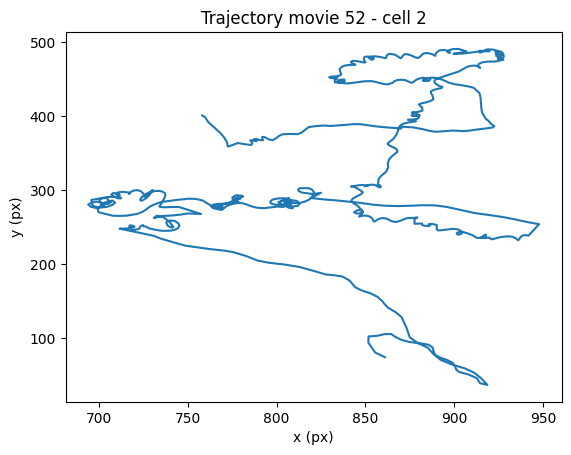

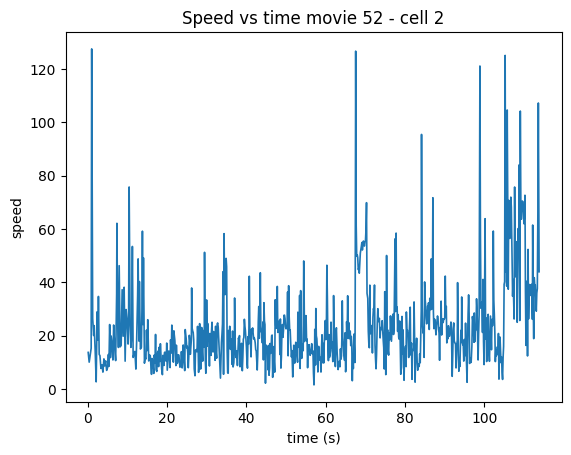

In [ ]:
# @title Pick longest track & visualize trajectory / speed
def pick_longest_track(df):
    counts = df.groupby("cell_id")["frame"].count().sort_values(ascending=False)
    return int(counts.index[0])

def plot_track(df, cid, title=""):
    sub = df[df["cell_id"]==cid].copy()
    sub = sub[sub["dt_sec"]>0]
    if sub.empty:
        print("Empty track.")
        return
    plt.figure()
    plt.plot(sub["x"].values, sub["y"].values, linewidth=1.5)
    # plt.gca().invert_yaxis()
    plt.xlabel("x (px)")
    plt.ylabel("y (px)")
    plt.title(f"Trajectory {title} - cell {cid}")
    plt.show()

    plt.figure()
    plt.plot(sub["t_sec"].values, sub["v_speed"].values, linewidth=1.2)
    plt.xlabel("time (s)")
    plt.ylabel("speed")
    plt.title(f"Speed vs time {title} - cell {cid}")
    plt.show()
df52p = pd.read_csv("/content/clean_movie_52_with_speed.csv")
cid52 = pick_longest_track(df52p)

plot_track(df52p, cid52, "movie 52")



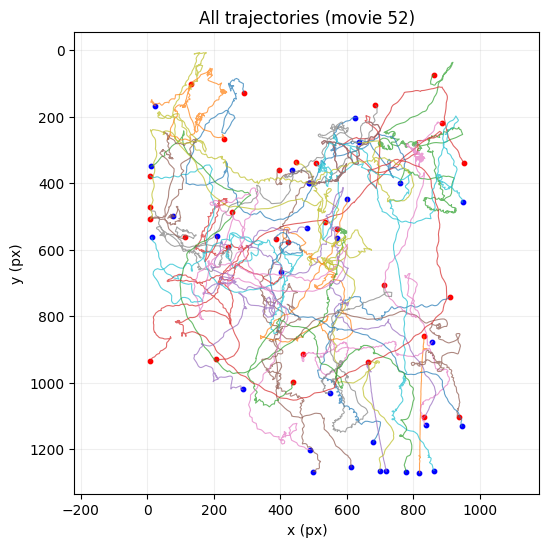

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/clean_movie_52_with_speed.csv")

plt.figure(figsize=(6,6))
for cid, g in df.sort_values(["cell_id","t_sec"]).groupby("cell_id"):
    g = g[g["dt_sec"]>0]
    if len(g) == 0:
        continue
    plt.plot(g["x"].values, g["y"].values, lw=0.8, alpha=0.7)
    x0,y0=float(g["x"].values[0]),float(g["y"].values[0])
    x1,y1=float(g["x"].values[-1]),float(g["y"].values[-1])
    plt.scatter([x0],[y0],c='b',s=10,label='start')
    plt.scatter([x1],[y1],c='r',s=10,label='end')
    # plt.legend()

plt.gca().invert_yaxis()
plt.axis('equal')
plt.xlabel("x (px)"); plt.ylabel("y (px)")
plt.title("All trajectories (movie 52)")
plt.grid(alpha=0.2)
plt.show()


In [ ]:
(df52p['dt_sec']<=0).sum(), df52p['dt_sec'].isna().sum()

(np.int64(30), np.int64(0))

There are 30 trajectories

We can get the position of the light source directly from the capture

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

def detect_light_center_numpy(img_path, percentile=99.5, use_weight=True):
    """
    从图片自动估计光源中心:
    1) 转灰度
    2) 用亮度分位数(如 99.5%)阈值二值化
    3) 在阈值以上的像素做(加权)质心
    返回: (cx, cy), gray, mask
      注意坐标单位是图像像素，(0,0) 左上角；y 向下
    """
    img = imageio.imread(img_path)  # (H,W,[C])
    if img.ndim == 3:
        gray = img.mean(axis=2).astype(float)
    else:
        gray = img.astype(float)
    H, W = gray.shape

    thr = np.percentile(gray, percentile)   # 高亮阈值
    mask = gray >= thr                      # 亮区
    if mask.sum() == 0:
        raise ValueError("highlight area not detected")

    ys, xs = np.nonzero(mask)
    if use_weight:
        w = gray[mask]                      # 用亮度做权重
        cx = float((xs * w).sum() / w.sum())
        cy = float((ys * w).sum() / w.sum())
    else:
        cx = float(xs.mean()); cy = float(ys.mean())
    return (cx, cy), gray, mask


In [ ]:
def plot_all_trajectories_with_light(df, light_xy, img_path=None,
                                     show_image=False, invert_y=True):
    """
    df: 轨迹表，列含 x,y,cell_id,dt_sec
    light_xy: (cx,cy) from image (像素坐标, 原点左上)
    img_path: 可选，叠加背景图像
    """
    cx, cy = light_xy
    plt.figure(figsize=(6,6))

    if img_path and show_image:
        import imageio.v2 as imageio
        img = imageio.imread(img_path)
        plt.imshow(img)
    # 画轨迹
    for cid, g in df.groupby("cell_id"):
        g = g[g["dt_sec"]>0]
        if len(g)==0: continue
        plt.plot(g["x"].values, g["y"].values, lw=0.7, alpha=0.8)
        x0,y0=float(g["x"].values[0]),float(g["y"].values[0])
        x1,y1=float(g["x"].values[-1]),float(g["y"].values[-1])
        plt.scatter([x0],[y0],c='b',s=10)
        plt.scatter([x1],[y1],c='r',s=10)
    # 光心
    plt.scatter([cx],[cy], marker='*', s=220, c='red', label='light center')

    if invert_y: plt.gca().invert_yaxis()   # 图像坐标 y 向下
    plt.axis('equal'); plt.grid(alpha=0.2)
    plt.xlabel("x (px)"); plt.ylabel("y (px)")
    plt.title("All trajectories with light center")
    plt.legend(loc="best")
    plt.show()


light center (px): (252.10614313608545, 335.41309535888786)


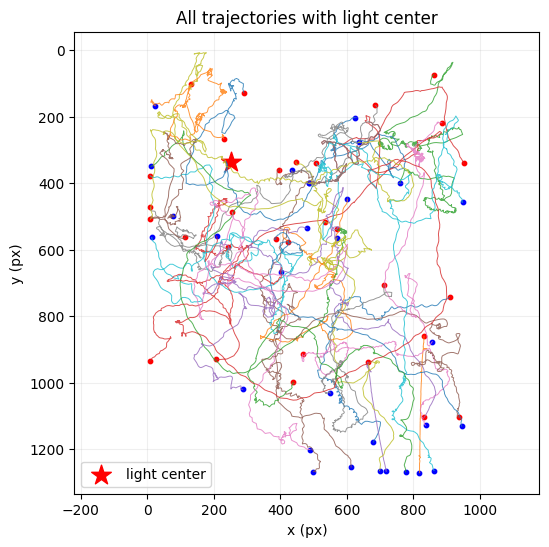

In [ ]:
IMG = "/content/drive/MyDrive/Colab_Notebooks/internship/test.jpeg"
(light_xy, gray, mask) = detect_light_center_numpy(IMG, percentile=99.5)
print("light center (px):", light_xy)

# put the light center on the plot of all trajectories
plot_all_trajectories_with_light(df, light_xy, img_path=IMG, show_image=False)





## 3) Forward-aligned interval features

For each trajectory, row $i$ represents a frame $f_i$, while action applies on the **interval**
$$
\mathcal{I}_i = [t_i,,t_{i+1})\quad (i=0,\ldots,n_c-2).
$$
We therefore **forward-align** the interval features to the next row:
$$
v^{\mathrm{fwd}}_i \equiv |v_{i+1}|,\qquad
\omega^{\mathrm{fwd}}_i \equiv \omega_{i+1}.
$$

and we **write the label of interval (\mathcal{I}_i) into row (i+1)**:

* first row has no label (there is no preceding interval),
* the last row receives the label of the last interval.



## 4) run / tumble labeling rule

We assign a discrete action $a_i\in\{0=\mathrm{run},1=\mathrm{tumble}\}$ to each interval $\mathcal{I}_i$ using two thresholds:

1. **Low-speed threshold** (global robust estimate from all intervals):
   $$
   \varepsilon_v = \operatorname{Quantile}_q\big({v^{\mathrm{fwd}}_i}\big),\quad q\in[0,1]\ \text{(e.g. }q=0.05\text{)}.
   $$

2. **High-turn threshold** from a **2-means** clustering on $|\omega^{\mathrm{fwd}}|$:
   Fit KMeans with $K=2$ to $\{|\omega^{\mathrm{fwd}}_i|\}$, obtain centers
   $\mu_{\text{lo}}\le\mu_{\text{hi}}$, and set
   $$
   \tau_\omega = \frac{\mu_{\text{lo}}+\mu_{\text{hi}}}{2}.
   $$
   <!-- (Fallback when samples are scarce: $\tau_\omega = 3\cdot\operatorname{median}(|\omega^{\mathrm{fwd}}|)+\epsilon$.) -->

**Decision rule (per interval $\mathcal{I}_i$)**:
$$
a_i=
\begin{cases}
1 & \text{if } v^{\mathrm{fwd}}_i  \le \varepsilon_v \wedge |\omega^{\mathrm{fwd}}_i|>\tau_\omega \quad\text{(near-stationary & large turn)},
\\
0 & \text{otherwise (run)}.
\end{cases}
$$

If $\omega^{\mathrm{fwd}}_i$ is invalid (NaN/inf), we fall back to the speed criterion:
$$
a_i = \mathbb{1}\{v^{\mathrm{fwd}}_i\le\varepsilon_v\}.
$$

Finally we **write action** $a_i$ to row $i+1$:
$$
\text{row }(i+1).\text{action_id} = a_i,\qquad
\text{row }0.\text{action_id}=\mathrm{NaN}.
$$
We also map `action_id → {'run','tumble'}`.

---



* DTI gives **movie-level** intervals between consecutive global frames; building $t_{\text{abs}}(f)$ ensures that every trajectory—no matter where it starts or how many frames it skips—uses the **true elapsed time** between its samples.
* Velocities and angular speeds are computed on exact $\Delta t$, so the interval features $(v^{\mathrm{fwd}},\omega^{\mathrm{fwd}})$ are faithful descriptors of $[t_i,t_{i+1})$.
* Forward-aligned labeling avoids the “action on first row” ambiguity and makes the table consistent with the POMDP step semantics.

---
<!--
### Pseudocode (what your code already does)

1. Read CSV → sort by `(cell_id, frame)`.
2. Build `t_abs_sec = T(frame - f_min)` from DTI; per cell set `t_sec = t_abs - t_abs[first]`, `dt_sec = diff(t_abs)`.
3. Compute `dx,dy → vx,vy,v_speed`; `heading = atan2(dy,dx)`; `ang_vel = wrap(diff(heading))/dt_sec`.
4. Forward features: `v_fwd=v_speed.shift(-1)`, `w_fwd=ang_vel.shift(-1)`.
5. Compute thresholds:
   (\varepsilon_v = \mathrm{Quantile}*q(v^{\mathrm{fwd}})),
   (\tau*\omega = \tfrac{1}{2}(\mu_{\text{lo}}+\mu_{\text{hi}})) from KMeans on (|\omega^{\mathrm{fwd}}|).
6. For each cell, create interval labels (a_i) by the rule above and write them to row (i+1).
   First row stays NaN; last row has a label.
   Add `action_id ∈ {0,1}` and `action ∈ {'run','tumble'}`. -->




### add actions to the data

In [ ]:
import numpy as np, pandas as pd
from sklearn.cluster import KMeans

def assign_actions_next_row(df: pd.DataFrame, speed_q=0.05, min_dwell_frames=0, return_str=True):
    """
    Rules:
      - tumble ⇐ (low speed) AND (high angular speed)
      - when angular speed invalid，only determine with low speed
      - 可选: min_dwell_frames>=2 时合并短段，抑制抖动

    输入列要求:
      cell_id, t_sec, v_speed, ang_vel_rad_s
    输出:
      action_id ∈ {0,1}, 以及可选 action ∈ {'run','tumble'}
    """
    need = {"cell_id", "t_sec", "v_speed", "ang_vel_rad_s"}
    missing = need - set(df.columns)
    if missing:
        raise ValueError(f"df miss column: {missing}")

    out = df.sort_values(["cell_id","t_sec"]).copy()

    # forward-alignment: 把 [t_i -> t_{i+1}) 的特征写到行 i+1
    out["v_fwd"] = out.groupby("cell_id")["v_speed"].shift(-1)
    out["w_fwd"] = out.groupby("cell_id")["ang_vel_rad_s"].shift(-1)

    # ========= 全局阈值 =========
    v_all = out["v_fwd"].replace([np.inf,-np.inf], np.nan).dropna().to_numpy()
    w_all = out["w_fwd"].replace([np.inf,-np.inf], np.nan).dropna().to_numpy()

    # 低速阈值（分位数）
    eps_v = float(max(1e-6, np.nanquantile(v_all, speed_q) if v_all.size else 1e-3))

    # 角速率阈值（KMeans 两簇中点）
    km = KMeans(n_clusters=2, n_init=10, random_state=0)
    labels = km.fit_predict(np.abs(w_all).reshape(-1,1)) if w_all.size else np.array([0,1])
    centers = np.sort(km.cluster_centers_.ravel()) if w_all.size else np.array([0.0, 1.0])
    tau_omega = float((centers[0] + centers[1]) / 2.0)

    # ========= 打标签 =========
    out["action_id"] = pd.Series(np.nan, index=out.index, dtype=pd.Int64Dtype())

    def _merge_short_segments(arr, min_len):
        """把长度 < min_len 的短段并到两侧多数（简单 RLE）。"""
        if min_len <= 1:
            return arr
        arr2 = arr.copy()
        i = 0
        L = len(arr2)
        while i < L:
            j = i
            while j < L and arr2[j] == arr2[i]:
                j += 1
            seg_len = j - i
            if seg_len < min_len:
                left  = arr2[i-1] if i-1 >= 0 else arr2[j] if j < L else arr2[i]
                right = arr2[j]   if j   < L else left
                fill  = left if left == right else right
                arr2[i:j] = fill
            i = j
        return arr2

    for cid, g in out.groupby("cell_id"):
        idx = g.index.to_numpy()
        v   = g["v_fwd"].to_numpy()
        w   = g["w_fwd"].to_numpy()
        n   = len(g)
        if n <= 1:
            continue

        a_int = np.zeros(n-1, dtype=int)  # 默认 run=0

        low = (v[:-1] <= eps_v)
        valid_w = np.isfinite(w[:-1])
        hiw = np.zeros_like(low, dtype=bool)
        hiw[valid_w] = (np.abs(w[:-1][valid_w]) > tau_omega)

        # ==== AND 规则（仅此处区别于你的旧代码）====
        #  只有同时满足 低速 + 高角速率 的区间标为 tumble
        a_int[low & hiw] = 1

        # 若角速度无效：保守地只看低速（不再因仅高ω而标正）
        a_int[~valid_w] = (low[~valid_w]).astype(int)

        # 合并最短停留（可选）
        if min_dwell_frames and min_dwell_frames >= 2:
            a_int = _merge_short_segments(a_int, min_dwell_frames)

        # 把区间动作写到下一行
        out.loc[idx[1:], "action_id"] = a_int

    if return_str:
        out["action"] = out["action_id"].map({0:"run", 1:"tumble"})

    # 清理中间列
    out = out.drop(columns=["v_fwd","w_fwd"])

    return out, {"tau_omega": tau_omega, "eps_v": eps_v}


In [ ]:
df=pd.read_csv('/content/clean_movie_52_with_speed.csv')
df, th = assign_actions_next_row(df,speed_q=0.1)
print(th)
df.head(12)


{'tau_omega': 8.453528338507574, 'eps_v': 4.5279757529151725}


,frame,x,y,cell_id,t_abs_sec,t_sec,dt_sec,dx,dy,vx,vy,v_speed,heading_rad,ang_vel_rad_s,action_id,action
0,64.0,677.612638,1187.600217,0,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
1,65.0,679.265230,1178.830878,0,0.13,0.13,0.13,1.652592,-8.769339,12.712248,-67.456455,68.643824,-1.384530,NaN,0,run
2,66.0,683.688730,1170.357778,0,0.26,0.26,0.13,4.423500,-8.473100,34.026921,-65.177692,73.525254,-1.089654,2.268276,0,run
3,67.0,687.980679,1164.028699,0,0.39,0.39,0.13,4.291949,-6.329079,33.014990,-48.685222,58.823808,-0.974898,0.882734,0,run
4,68.0,694.142970,1150.810408,0,0.46,0.46,0.07,6.162291,-13.218291,88.032731,-188.832726,208.344811,-1.134557,-2.280840,0,run
5,69.0,696.122283,1145.030460,0,0.59,0.59,0.13,1.979313,-5.779948,15.225484,-44.461140,46.995833,-1.240868,-0.817776,0,run
6,70.0,697.292246,1140.051427,0,0.72,0.72,0.13,1.169963,-4.979033,8.999712,-38.300256,39.343416,-1.340005,-0.762595,0,run
7,71.0,697.993080,1135.548002,0,0.85,0.85,0.13,0.700835,-4.503424,5.391035,-34.641727,35.058701,-1.416412,-0.587744,0,run
8,72.0,699.977511,1129.465103,0,0.98,0.98,0.13,1.984431,-6.082899,15.264851,-46.791530,49.218523,-1.255451,1.238159,0,run
9,73.0,700.119087,1126.391719,0,1.17,1.17,0.19,0.141576,-3.073384,0.745138,-16.175707,16.192860,-1.524764,-1.417433,0,run


In [ ]:
df.to_csv('/content/clean_movie_52_with_speed_and_action.csv')

In [ ]:
(df["action_id"]==1).mean()

np.float64(0.033005178398679794)

biophysical model

In [ ]:

import numpy as np

# ---------- tool ----------
def _normalize(v, eps=1e-12):
    v = np.asarray(v, float); n = np.linalg.norm(v) + eps
    return v / n

def _R2(a):
    c, s = np.cos(a), np.sin(a)
    return np.array([[c,-s],[s,c]], float)

# ---------- geometry of the agent ----------
class CircularAgent:
    def __init__(self, center, radius, heading_angle_deg, beta_deg=30.0, alpha_deg=20.0, fov_deg=60.0):
        self.x   = np.array(center, float)
        self.R   = float(radius)
        self.d   = _R2(np.deg2rad(heading_angle_deg)) @ np.array([1.0,0.0])
        self.d   = _normalize(self.d)
        self.beta= np.deg2rad(beta_deg)
        self.alpha=np.deg2rad(alpha_deg)
        self.fov = np.deg2rad(fov_deg)
        # eyespot
        self.xL  = self.x + self.R * (_R2(+self.beta) @ self.d)
        self.xR  = self.x + self.R * (_R2(-self.beta) @ self.d)
        # optical axis
        self.uL  = _normalize(_R2(+self.alpha) @ self.d)
        self.uR  = _normalize(_R2(-self.alpha) @ self.d)
        # normal
        self.nL  = _normalize(self.xL - self.x)
        self.nR  = _normalize(self.xR - self.x)

# ---------- visibility gates ----------
def _occ_gate(n_eye, dir_to_src):
    # occlusion gate
    return 1.0 if float(np.dot(n_eye, dir_to_src)) >= 0.0 else 0.0

def _fov_gate(u_eye, dir_to_src, fov_half_angle_rad):
    # fov gate
    return 1.0 if float(np.dot(u_eye, dir_to_src)) >= np.cos(fov_half_angle_rad) else 0.0

# ---------- light diffusion ----------
def _gaussian_blob(I0, mu, sigma, at_point):
    r  = at_point - mu
    r2 = float(np.dot(r,r))
    return I0 * np.exp(-0.5 * r2 / (sigma**2))

def _invsq(r2, eps=1e-6):  # aerial
    return 1.0 / (r2 + eps)

def _logistic_distance(s, beta_d=0.5):  # under water
    return 1.0 / (1.0 + np.exp(beta_d * s))

def _per_eye_I(agent, mu, I0=1.0, sigma=1.0, use_invsq=False, use_logdist=True, beta_d=0.5):
    out = {}
    for side in ("L","R"):
        x_eye = getattr(agent, f"x{side}")
        u_eye = getattr(agent, f"u{side}")
        n_eye = getattr(agent, f"n{side}")
        dir_to_src = _normalize(mu - x_eye)
        rvec = x_eye - mu; r2 = float(np.dot(rvec,rvec)); s = np.sqrt(r2)
        occ = _occ_gate(n_eye, dir_to_src)
        fov = _fov_gate(u_eye, dir_to_src, agent.fov)
        g   = occ * fov                         # 早期门控（方案A）
        base= _gaussian_blob(I0, mu, sigma, x_eye)
        if use_invsq:      base *= _invsq(r2)
        if use_logdist:    base *= _logistic_distance(s, beta_d=beta_d)
        cos_inc = max(0.0, float(np.dot(u_eye, dir_to_src)))   # 入射余弦 [·]_+
        out[side] = dict(I = g * base * cos_inc,
                         occ=occ, fov=fov, cos_inc=cos_inc, s=s, r2=r2)
    return out

# ---------- saturation ----------
def _S_logistic(I, beta_s=3.0, I50=0.01):
    #saturation: S(I)=1/(1+exp(-β_s (I-I50)))
    return 1.0 / (1.0 + np.exp(-beta_s * (I - I50)))

def _bin_strong_weak(y, thr=0.5):   # m=2 的二档
    return 1 if y >= thr else 0

# ---------- observation ----------
def observation_biophysical(x, xl, v, n, m,
              geom,src,sensor):
    """
    return (o_L, o_R) ∈ {0,...,m-1}^2；
    """
    # heading
    heading_angle_deg = float(np.rad2deg(np.arctan2(v[1], v[0])))
    agent = CircularAgent(center=x, radius=geom["R"], heading_angle_deg=heading_angle_deg,
                          beta_deg=geom["beta_deg"], alpha_deg=geom["alpha_deg"], fov_deg=geom["fov_deg"])
    per_eye = _per_eye_I(agent, np.asarray(src["mu"], float),
                         I0=src["I0"], sigma=src["sigma"],
                         use_invsq=src["use_invsq"], use_logdist=src["use_logdist"], beta_d=src["beta_d"])
    IL = per_eye["L"]["I"]; IR = per_eye["R"]["I"]
    yL = _S_logistic(IL, beta_s=sensor["beta_s"], I50=sensor["I50"])
    yR = _S_logistic(IR, beta_s=sensor["beta_s"], I50=sensor["I50"])
    oL = _bin_strong_weak(yL, thr=sensor["thr"])
    oR = _bin_strong_weak(yR, thr=sensor["thr"])
    return np.array([oL, oR], dtype=int)

# ---------- transition + emission matrix ----------
def init_transition_biophysical(n, m, a,
                geom, src, sensor,
                ref_x=np.array([0.0,0.0]), ref_xl=None, eps_col=0.1):

    import torch
    # same tranisiton matrix as before
    T= torch.zeros([a,n,n])
    Z=torch.zeros([m,m,n])



    T[0]= torch.eye(n)
    T= T+0.1*torch.ones([a,n,n])

    # for every hidden state (prototype) build a reference velocity
    for h in range(n):
        theta = 2*np.pi*h/n
        v_ref = np.array([np.cos(theta), np.sin(theta)], float)
        if ref_xl is None:
            ref_xl = np.asarray(src["mu"], float)  # light source
        o = observation_biophysical(ref_x, ref_xl, v_ref, n, m, geom, src, sensor)  # (oL,oR)
        # weighted and normalization as before for the emission matrix
        Z[o[0], o[1], h] = 10.0
    Z = Z + eps_col * torch.ones_like(Z)
    # column normalization
    Z = Z.reshape(m*m, n)
    Z = Z / torch.clamp(Z.sum(dim=0, keepdim=True), min=1e-12)
    Z = Z.reshape(m, m, n)


    def normalize_t(TT):
        sh = TT.shape
        out = torch.einsum('...ij,k->...kj', TT, torch.ones(sh[-2], dtype=TT.dtype, device=TT.device))
        return TT / out
    return normalize_t(T), Z


In [ ]:
import torch
import numpy as np
import math


def update(b,o,a,TT,ZZ):
    #update belief
    v=np.zeros(len(b))
    o1=o[0]
    o2=o[1]
    for i in range(len(b)):
        v[i]=ZZ[o1,o2,i]*b[i]
    return v/v.sum()

We cut trajectories into steps $(x_t,v_t,\Delta t_t)\to(x_{t+1},v_{t+1})$.  
At each step we build a POMDP belief state $s_t \equiv b_t^+ \in \Delta^{n-1}$ by
$$
o_t=\text{obs}(x_t,v_t),\qquad b_t^+=\text{update}(b_{t-1},o_t).
$$
<!-- 这里还要确认是不是用了生物模型计算了o，要写入df中 -->


In [ ]:
class Env:
  def __init__(self,geom,src,sensor,TT,ZZ):
    self.geom=geom
    self.src=src
    self.sensor=sensor
    self.TT=TT
    self.ZZ=ZZ


In [ ]:

#Example

n=5
m=2


r=torch.zeros(n)

r[0]=10
r[1]=r[-1]=8

a=2
geom   = dict(R=0.2, beta_deg=30, alpha_deg=20, fov_deg=60)
src    = dict(I0=1.0, mu=light_xy, sigma=np.linalg.norm(light_xy)/np.sqrt(2),
              use_invsq=False, use_logdist=True, beta_d=0.01)
sensor = dict(beta_s=5.0, I50=0.005, thr=0.5)

df=pd.read_csv('/content/clean_movie_52_with_speed_and_action.csv').sort_values(["cell_id","t_sec"]).reset_index(drop=True)

df_use = df[df["dt_sec"]>0].sort_values(["cell_id","t_sec"]).copy()

# ga_s, ga_e = fit_start_end_gaussian(df_use, k=10)
# sampler    = ref_sampler_from_gaussian(ga_s, ga_e, seed=0)
# ZZ_bar     = build_Z_avg(n, m, a, geom, src, sensor, sampler, M=16)
TT,ZZ = init_transition_biophysical(n, m, a, geom, src, sensor,
                  ref_x=np.array([0.0,0.0]),
                  ref_xl=np.array(src["mu"]))

env=Env(geom,src,sensor,TT,ZZ)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# ---------- A) 统计实验时序，选择统一步长 ----------
def summarize_dwell(df):
    g = df[df["dt_sec"]>0].sort_values(["cell_id","t_sec"]).copy()
    segs=[]
    for cid, gi in g.groupby("cell_id"):
        a  = gi["action_id"].to_numpy()
        dt = gi["dt_sec"].to_numpy()
        cur=a[0]; acc=0.0
        for ai, di in zip(a, dt):
            if ai==cur: acc += di
            else:
                segs.append((cid, cur, acc))
                cur=ai; acc=di
        segs.append((cid, cur, acc))
    seg = pd.DataFrame(segs, columns=["cell_id","action","dwell_sec"])
    mean_tum = float(seg.loc[seg.action==1, "dwell_sec"].mean())
    frame_dt = float(g["dt_sec"].median())
    return dict(mean_tum=mean_tum, frame_dt=frame_dt)

def choose_dt_policy(mean_tum, frame_dt, steps_per_tum=3):
    raw = mean_tum / float(steps_per_tum)
    k = max(1, int(round(raw / frame_dt)))
    return k * frame_dt, k

# ---------- B) 线性插值重采样到固定 dt ----------
def _interp_row(r0, r1, t_target):
    t0, t1 = float(r0["t_sec"]), float(r1["t_sec"])
    if t1 <= t0:
        return dict(x=float(r1["x"]), y=float(r1["y"]),
                    vx=float(r1["vx"]), vy=float(r1["vy"]), t_sec=float(t1))
    a = (t_target - t0) / max(t1 - t0, 1e-12)
    x  = (1-a)*float(r0["x"])  + a*float(r1["x"])
    y  = (1-a)*float(r0["y"])  + a*float(r1["y"])
    vx = (1-a)*float(r0["vx"]) + a*float(r1["vx"])
    vy = (1-a)*float(r0["vy"]) + a*float(r1["vy"])
    return dict(x=x, y=y, vx=vx, vy=vy, t_sec=t_target)

def regrid_to_uniform_dt_linear(df_use, env, n, m, dt_target,
                                speed_q=0.10, omega_method="kmeans",
                                label_mode="major_from_raw"):  # 'major_from_raw' | 'AND'
    df = df_use[df_use["dt_sec"]>0].sort_values(["cell_id","t_sec"]).copy()
    rows=[]
    mu = np.asarray(env.src["mu"], float)

    for cid, g in df.groupby("cell_id"):
        gi = g.reset_index(drop=True)
        if gi.shape[0] < 2:
            continue

        t_start = float(gi.loc[0, "t_sec"])
        t_end_all = float(gi.loc[len(gi)-1, "t_sec"])
        cur = dict(x=float(gi.loc[0,"x"]), y=float(gi.loc[0,"y"]),
                   vx=float(gi.loc[0,"vx"]), vy=float(gi.loc[0,"vy"]),
                   t_sec=float(gi.loc[0,"t_sec"]))
        target = t_start + dt_target
        j = 1

        # 为“多数占比标签”准备原始区间端点（每条原始帧区间 [ti,ti+1)）
        t_i  = gi["t_sec"].to_numpy()
        dt_i = gi["dt_sec"].to_numpy()
        t_i1 = t_i + dt_i
        a_i  = gi["action_id"].to_numpy().astype(int)

        while target <= t_end_all and j < len(gi):
            while j < len(gi) and float(gi.loc[j, "t_sec"]) < target:
                j += 1
            if j >= len(gi):
                break
            r0 = gi.loc[j-1]; r1 = gi.loc[j]
            nxt = _interp_row(r0, r1, target)

            x0 = np.array([cur["x"], cur["y"]], float)
            v0 = np.array([cur["vx"], cur["vy"]], float)
            x1 = np.array([nxt["x"], nxt["y"]], float)
            v1 = np.array([nxt["vx"], nxt["vy"]], float)
            if not (np.isfinite(v0).all() and np.isfinite(v1).all()):
                cur = nxt; target += dt_target; continue

            # 观测
            o  = observation_biophysical(x0, mu, v0, n, m, env.geom, env.src, env.sensor)
            o1 = observation_biophysical(x1, mu, v1, n, m, env.geom, env.src, env.sensor)
            o_idx  = int(o[0])*m + int(o[1])
            o1_idx = int(o1[0])*m + int(o1[1])

            row = dict(
                cell_id=cid,
                t_start=cur["t_sec"], t_end=nxt["t_sec"], dt=float(dt_target),
                x0=x0[0], y0=x0[1], vx0=v0[0], vy0=v0[1],
                x1=x1[0], y1=x1[1], vx1=v1[0], vy1=v1[1],
                o_idx=o_idx, o1_idx=o1_idx
            )

            # —— 统一网格上的标签 —— #
            if label_mode == "major_from_raw":
                # 计算本窗口与原始每个区间的重叠长度
                T0, T1 = row["t_start"], row["t_end"]
                overlap = np.maximum(0.0, np.minimum(T1, t_i1) - np.maximum(T0, t_i))
                tum_time = float((overlap * (a_i==1)).sum())
                frac = tum_time / max(T1-T0, 1e-12)

                row["a_major"] = int(frac >= 0.5)
                row["a"]       = row["a_major"]   # <<—— 直接把 a 设成 a_major
            else:
                # 原先 AND 方法：先算 v_disp 与 |omega| 再阈值（会在后面批量算）
                pass

            rows.append(row)
            cur = nxt
            target += dt_target

    df_grid = pd.DataFrame(rows)
    if df_grid.empty:
        return df_grid, {"eps_v": np.nan, "tau_w": np.nan}

    if label_mode == "major_from_raw":
        # 我们已经写好了 a，无需 AND 阈值
        return df_grid, {"eps_v": np.nan, "tau_w": np.nan}

    # ====== 以下仅在 label_mode='AND' 时执行（与你旧逻辑一致） ======
    disp = np.hypot(df_grid["x1"]-df_grid["x0"], df_grid["y1"]-df_grid["y0"]).to_numpy()
    v_disp = disp / np.clip(df_grid["dt"].to_numpy(), 1e-12, None)
    th0 = np.arctan2(df_grid["vy0"], df_grid["vx0"]).to_numpy()
    th1 = np.arctan2(df_grid["vy1"], df_grid["vx1"]).to_numpy()
    dth = np.arctan2(np.sin(th1-th0), np.cos(th1-th0))
    omega = dth / np.clip(df_grid["dt"].to_numpy(), 1e-12, None)
    df_grid["v_disp"] = v_disp
    df_grid["omega"]  = omega

    v_all = np.asarray(v_disp)
    w_all = np.abs(np.asarray(omega))
    eps_v = float(np.nanquantile(v_all, speed_q)) if np.isfinite(v_all).any() else 1e-3
    if omega_method=="kmeans" and np.isfinite(w_all).sum() >= 20:
        km = KMeans(n_clusters=2, n_init=10, random_state=0)
        labels = km.fit_predict(w_all[~np.isnan(w_all)].reshape(-1,1))
        centers = np.sort(km.cluster_centers_.ravel())
        tau_w = float((centers[0]+centers[1]) / 2.0)
    else:
        tau_w = float(np.nanquantile(w_all, 0.90)) if np.isfinite(w_all).any() else 0.0

    df_grid["a"] = ((df_grid["v_disp"] <= eps_v) & (np.abs(df_grid["omega"]) >= tau_w)).astype(int)
    return df_grid, {"eps_v": eps_v, "tau_w": tau_w}


# ---------- C) df_grid -> samples ----------
def samples_from_grid(df_grid):
    samples=[]
    for _, r in df_grid.iterrows():
        samples.append(dict(
            o_idx  = int(r["o_idx"]),
            dt     = float(r["dt"]),
            x0     = np.array([r["x0"], r["y0"]], float),
            v0     = np.array([r["vx0"], r["vy0"]], float),
            x1     = np.array([r["x1"], r["y1"]], float),
            v1     = np.array([r["vx1"], r["vy1"]], float),
            o1_idx = int(r["o1_idx"]),
            a      = int(r["a"])
        ))
    return samples

In [ ]:

# ---------- D) 调用 ----------
# 1) 用“AND 重标”的 df 统计并选择 dt（建议先把原 df 用 AND 规则重标一次，再统计）
stats = summarize_dwell(df)  # df 是你用 AND 规则生成的新版标签表
print("Stats:", stats)

dt_policy, k_frames = choose_dt_policy(stats["mean_tum"], stats["frame_dt"], steps_per_tum=3)
print(f"Δt_policy = {dt_policy:.3f}s  (~{k_frames} frames)")

# 2) 重采样到固定 dt，并在统一网格上用 AND 规则打标签
df_grid, th = regrid_to_uniform_dt_linear(df_use, env, n, m, dt_target=dt_policy,
                  speed_q=0.10, omega_method="kmeans")
print("uniform df_grid:", df_grid.shape)

# 3) 转 samples（供 policy 训练/IRL/仿真）
samples = samples_from_grid(df_grid)
print(f"Generated {len(samples)} samples with fixed dt={dt_policy:.3f}.")

Stats: {'mean_tum': 0.3215503875968904, 'frame_dt': 0.1299999999999954}
Δt_policy = 0.130s  (~1 frames)
uniform df_grid: (20420, 16)
Generated 20420 samples with fixed dt=0.130.


In [ ]:
(df_grid["a"]==1).mean()

np.float64(0.030950048971596474)

In [ ]:
import numpy as np

def expected_uniform_steps_per_cell(df, dt_policy):
    tot = 0
    for _, g in df[df["dt_sec"]>0].groupby("cell_id"):
        t = g["t_sec"].to_numpy()
        if len(t) < 2:
            continue
        T = float(t[-1] - t[0])
        k = int(np.floor((T + 1e-9) / dt_policy))  # +eps 抵消浮点误差
        tot += k
    return tot

N_expected_cell = expected_uniform_steps_per_cell(df_use, dt_policy=0.13)
print("Expected by per-cell floor:", N_expected_cell)


Expected by per-cell floor: 20420


## Policy learning
**Bernoulli Policy (2-layer MLP).**  
Action $a\in\{0=\text{run},\,1=\text{tumble}\}$. The policy is
$$
p_t\;=\;\pi_\theta(a_t{=}1\mid o_t)\;=\;\sigma\!\Big(w_2^\top \sigma_{\rm hid}(W_1 onehot(o_t) + b_1) + b_2\Big),\quad
\pi_\theta(a_t{=}0\mid o_t)=1-p_t.
$$

需要把policy换成关于观测o而不是s的函数，loss也要换成关于o而不是s的

In [ ]:
def tensors_from_samples(samples, m, device=None, dtype=torch.float32):
    T = len(samples)
    X0 = torch.tensor(np.stack([s["x0"] for s in samples]), dtype=dtype, device=device)
    V0 = torch.tensor(np.stack([s["v0"] for s in samples]), dtype=dtype, device=device)
    X1 = torch.tensor(np.stack([s["x1"] for s in samples]), dtype=dtype, device=device)
    V1 = torch.tensor(np.stack([s["v1"] for s in samples]), dtype=dtype, device=device)
    DT = torch.tensor(np.array([s["dt"]     for s in samples]), dtype=dtype, device=device)
    idx= torch.tensor(np.array([s["o_idx"]  for s in samples]), dtype=torch.long, device=device)
    idx1=torch.tensor(np.array([s["o1_idx"] for s in samples]), dtype=torch.long, device=device)

    O = torch.zeros(T, m*m, dtype=dtype, device=device)
    O.scatter_(1, idx.unsqueeze(1), 1.0)   # one-hot(o_t)

    return dict(O=O, DT=DT, X0=X0, V0=V0, X1=X1, V1=V1, O_idx=idx, O1_idx=idx1)

In [ ]:
# ===== 3) 策略网络：πθ(a=1|o) = σ(MLP(onehot(o))) =====
import torch

def obs_onehot(o_idx: int, m: int, device=None, dtype=torch.float64):
    vec = torch.zeros(m*m, dtype=dtype, device=device)
    vec[int(o_idx)] = 1.0
    return vec

class BernoulliPolicyObs(torch.nn.Module):
    def __init__(self, m: int, hidden: int = 32):
        super().__init__()
        d_in = m*m
        self.net = torch.nn.Sequential(
            torch.nn.Linear(d_in, hidden, bias=True, dtype=torch.float32), # Changed dtype to float32
            torch.nn.Tanh(),
            torch.nn.Linear(hidden, 1, bias=True, dtype=torch.float32) # Changed dtype to float32
        )
        for m_ in self.net:
            if isinstance(m_, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m_.weight)
                torch.nn.init.zeros_(m_.bias)

    def forward(self, o_onehot: torch.Tensor) -> torch.Tensor:
        # o_onehot: (m*m,)
        return torch.sigmoid(self.net(o_onehot).squeeze(-1))   # p_tum ∈ (0,1)

In [ ]:
import torch, torch.nn.functional as F

class HazardPolicyObs(torch.nn.Module):
    """ π输出为 hazard h(o)≥0；一步概率 p_tum = 1 - exp(-h*dt) """
    def __init__(self, m: int, hidden: int = 32):
        super().__init__()
        d_in = m*m
        self.net = torch.nn.Sequential(
            torch.nn.Linear(d_in, hidden), torch.nn.Tanh(),
            torch.nn.Linear(hidden, 1)  # 输出logit_h，再softplus
        )
        for m_ in self.net:
            if isinstance(m_, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m_.weight); torch.nn.init.zeros_(m_.bias)

    def forward(self, O, DT):
        # O: (B, m*m) onehot; DT: (B,) 实际样本的 dt_sec
        logit_h = self.net(O).squeeze(-1)      # (B,)
        h = F.softplus(logit_h) + 1e-8         # hazard ≥ 0
        p_tum = 1.0 - torch.exp(-h * DT.clamp_min(1e-6))  # (B,)
        return p_tum, h


also learn the transition&emission matrix

**robust estimation and kinematic parametrization**

In the original code that updates the agent's movement (position and velocity) with different choice of actions:


```
def simu_env(x,v,a):
    #simulation de l'environement en fonction des actions
    #x position de l'algue,
    #xl position de la lumiere
    #v la direction de vitesse de l'algue
    #a l'action, run (0), tumble (1)

    # add randomness
    noise=0.4*(2*np.random.rand(2)-1)
    #noise=np.zeros(2)
    if a==1: #choice of a random direction
        vv= 2*np.random.rand(2)-1
        vv= vv/np.sqrt(vv@vv)
        vv=vv+noise
        xx=x+0.125*vv
    else:
        vv=v
        vv=vv+noise
        vv=vv/np.sqrt(vv@vv)
        xx=x+0.125*vv

    
    return (xx,vv)
```
Here we have to replace the constant `0.125` with estimated speed scales `c_run,c_tum` with real data.

* when the agent **runs**, it keeps its current heading $\hat u_t=\dfrac{v_t}{|v_t|+\varepsilon}$ and moves with speed $c_{\rm run}$:
$$
\hat x^{\rm run}_{t+1}=x_t+\Delta t_t\, c_{\rm run}\,\hat u_t,\qquad
\hat v^{\rm run}_{t+1}=c_{\rm run}\,\hat u_t.
$$
* when it **tumbles**, its heading is (approximately) isotropic and the speed scale is $c_{\rm tum}$ (typically $c_{\rm tum}\le c_{\rm run})$:
$$
\mathbb E\!\left[\|\hat x^{\rm tum}_{t+1}-x_{t+1}\|^2\right]=\|x_{t+1}-x_t\|^2+(\Delta t_t\,c_{\rm tum})^2,
$$
$$
\mathbb E\!\left[\|\hat v^{\rm tum}_{t+1}-v_{t+1}\|^2\right]=\|v_{t+1}\|^2+c_{\rm tum}^2.
$$




expected loss:
$$L_t(\theta,c)=\Delta t_t[(1-p_\theta(s_t))l^{\text{run}}(c_{\rm run})+p_{\theta}(s_t) l^{\text{tum}}(c_{\rm tum})]$$

<!-- total objective with regularization:
$$L(\theta,c)=\sum_t L_t(\theta)+\lambda_\theta ||\theta||^2_2+λ_cH$$ -->


---

## Robust initialization of $c_{\rm run},c_{\rm tum}$ from labels with **quantiles**

Let $\mathcal V_{\rm run}={,|v_i| : a_i=\text{run},}$ and $\mathcal V_{\rm tum}={,|v_i| : a_i=\text{tumble},}$ be the empirical speed sets computed on **forward–aligned** intervals. We initialize
$$
\boxed{
c_{\rm run}^{(0)} = Q_{0.75}\big(\mathcal V_{\rm run}\big),\qquad
c_{\rm tum}^{(0)} = Q_{0.25}\big(\mathcal V_{\rm tum}\big),
}
$$
where $Q_q$ denotes the empirical (q)-quantile.

<!-- Quantiles are **robust** to outliers/heavy tails (common in microscopy tracks due to missed detections or merges) and encode our prior ordering $c_{\rm tum}\le c_{\rm run}$ by construction (upper quantile for run, lower for tumble). When one class is scarce we fall back to robust location statistics (median–based defaults in code). -->

> **Gradient relevance.** The policy gradient magnitude scales with
> $$
> \Delta\ell_t = \ell_t^{\rm tum}(c_{\rm tum})-\ell_t^{\rm run}(c_{\rm run}).
> $$
<!-- > If the initial $(c_{\rm run}^{(0)},c_{\rm tum}^{(0)})$ are badly biased, $\Delta\ell_t$ becomes globally negative/positive, and the policy either saturates or learns slowly. Robust quantiles quickly place $(c_{\rm run}^{(0)},c_{\rm tum}^{(0)})$ near a **balanced** regime where $\Delta\ell_t$ changes sign across states, giving informative gradients. -->

---

## 2)  **tied, constrained** parameterization (`KinParamTie`)
We want to also train the kinematic params

We want **positivity** and the **ordering** $0<c_{\rm tum}\le c_{\rm run}$ to hold **for all updates**. We therefore reparameterize with two unconstrained scalars $(u,v)\in\mathbb R^2$:
$$
\boxed{
c_{\rm run}=\operatorname{softplus}(u)+\varepsilon,\qquad
c_{\rm tum}=\sigma(v) c_{\rm run},
}
$$
where $\operatorname{softplus}(u)=\log(1+e^{u})$ and $\sigma(v)=\dfrac{1}{1+e^{-v}}$. This guarantees
$$
c_{\rm run} > 0,\qquad 0<c_{\rm tum}<c_{\rm run}\quad (\text{since }0<\sigma(v)<1).
$$

---
Here $u$ controls golval speed scale (run/tumble speed change simutaneously) $v$ controls ratio $c_{\rm tum} / c_{\rm run} \in (0,1)$

### Initialization

Given robust initial guesses $(c_{\rm run}^{(0)},c_{\rm tum}^{(0)})$, we invert the above maps to place $(u,v)$ near a good range:
$$
u^{(0)}=\operatorname{softplus}^{-1}\big(c_{\rm run}^{(0)}-\varepsilon\big)
=\log\big(\exp(c_{\rm run}^{(0)}-\varepsilon)-1\big),
$$
$$
v^{(0)}=\operatorname{logit}\left(\frac{c_{\rm tum}^{(0)}}{c_{\rm run}^{(0)}}\right)
=\log\frac{c_{\rm tum}^{(0)}}{c_{\rm run}^{(0)}-c_{\rm tum}^{(0)}}.
$$

### gradient
Let $p_t=p_\theta(s_t)$. The derivatives of the single–step loss w.r.t. the **physical** speeds are
$$
\frac{\partial \mathcal L_t}{\partial c_{\rm run}}
=\Delta t_t(1-p_t),\frac{\partial \ell_t^{\rm run}}{\partial c_{\rm run}}\qquad
\frac{\partial \mathcal L_t}{\partial c_{\rm tum}}
=\Delta t_t p_t\frac{\partial \ell_t^{\rm tum}}{\partial c_{\rm tum}}.
$$


Chain rule to the unconstrained variables uses
$$
\frac{\partial c_{\rm run}}{\partial u}
=\sigma(u),\qquad
\frac{\partial c_{\rm tum}}{\partial v}
=\sigma(v)\big(1-\sigma(v)\big) c_{\rm run},
\qquad
\frac{\partial c_{\rm tum}}{\partial u}
=\sigma(v)\frac{\partial c_{\rm run}}{\partial u}.
$$
Thus
$$
\boxed{
\frac{\partial \mathcal L}{\partial u}
=\sum_t\left(\frac{\partial \mathcal L_t}{\partial c_{\rm run}}
+\frac{\partial \mathcal L_t}{\partial c_{\rm tum}}\sigma(v)\right)\sigma(u),\qquad
\frac{\partial \mathcal L}{\partial v}
=\sum_t \frac{\partial \mathcal L_t}{\partial c_{\rm tum}},
\sigma(v)\big(1-\sigma(v)\big),c_{\rm run}.
}
$$
This keeps updates **stable** (no sign flips, no invalid parameters) and implements the prior $c_{\rm tum}\le c_{\rm run}$ by design.

---






In [ ]:
# ====== 1) robust estim kin：c_run / c_tumble ======
def estimate_kin_from_labels(df, run_id=0, tum_id=1):
    v = df[["action_id","v_speed"]].replace([np.inf,-np.inf], np.nan).dropna()
    v_run = v.loc[v["action_id"]==run_id, "v_speed"].to_numpy()
    v_tum = v.loc[v["action_id"]==tum_id, "v_speed"].to_numpy()

    c_run = float(np.nanquantile(v_run, 0.75)) if v_run.size else float(np.nanmedian(v["v_speed"]))
    c_tum = float(np.nanquantile(v_tum, 0.25)) if v_tum.size else float(np.nanmedian(v["v_speed"])*0.5)
    return {"c_run": c_run, "c_tum": c_tum}

kin_init = estimate_kin_from_labels(df)
print("Kinematics from labels:", kin_init)


Kinematics from labels: {'c_run': 31.96004719483992, 'c_tum': 0.967376708494091}


In [ ]:
# ===== 4) 可学习的运动学常数 (c_run, c_tum) =====
import math

class KinParamTie(torch.nn.Module):
    """
    c_run = softplus(u)+eps,   c_tum = sigmoid(v)*c_run  (0 < c_tum <= c_run)
    """
    def __init__(self, c_run0: float, c_tum0: float, eps=1e-6):
        super().__init__()
        self.eps = eps
        u0 = math.log(math.exp(max(c_run0 - eps, 1e-8)) - 1.0)
        ratio0 = max(min(c_tum0 / max(c_run0, 1e-8), 0.999), 0.001)
        v0 = math.log(ratio0/(1-ratio0))
        self.u = torch.nn.Parameter(torch.tensor(u0, dtype=torch.float32)) # Change dtype to float32
        self.v = torch.nn.Parameter(torch.tensor(v0, dtype=torch.float32)) # Change dtype to float32

    def forward(self):
        c_run = torch.nn.functional.softplus(self.u) + self.eps
        ratio = torch.sigmoid(self.v)
        c_tum = ratio * c_run
        return c_run, c_tum

In [ ]:
# ========== Block A: 可学习 T/Z + 辅助函数（新增） ==========

import torch, numpy as np

def _to_np(a):
    return a if isinstance(a, np.ndarray) else np.asarray(a)

def _get_TT_ZZ_from_env(env):
    # 兼容 env.TT / env['TT'] 两种写法
    TT = getattr(env, 'TT', None)
    if TT is None and isinstance(env, dict): TT = env.get('TT', None)
    ZZ = getattr(env, 'ZZ', None)
    if ZZ is None and isinstance(env, dict): ZZ = env.get('ZZ', None)
    if TT is None or ZZ is None:
        raise ValueError("Cannot find TT/ZZ in env. Expect env.TT/env.ZZ or env['TT']/env['ZZ'].")
    return _to_np(TT), _to_np(ZZ)

def _split_T0(TT):
    """
    返回 T0_run, T0_tum，均为 (n,n) 列随机矩阵
    兼容：
      - dict: {0/1 or 'run'/'tumble' : (n,n)}
      - ndarray: (2,n,n) 或 (n,n,2) 或 单个 (n,n)（则两动作共用）
    """
    if isinstance(TT, dict):
        Tr = TT.get(0, TT.get('run', None))
        Tt = TT.get(1, TT.get('tumble', None))
        if Tr is None or Tt is None:
            raise ValueError("TT dict must contain keys 0/1 or 'run'/'tumble'.")
        return _to_np(Tr), _to_np(Tt)

    arr = _to_np(TT)
    if arr.ndim == 3:
        if arr.shape[0] == 2:       # (2,n,n)
            return arr[0], arr[1]
        if arr.shape[-1] == 2:      # (n,n,2)
            return arr[...,0], arr[...,1]
        raise ValueError(f"TT shape {arr.shape} not understood; expect 2 on one axis.")
    elif arr.ndim == 2:
        return arr, arr             # 单个矩阵，共用
    else:
        raise ValueError(f"TT ndim {arr.ndim} not supported.")

def _flatten_Z0(ZZ, m):
    """
    接受以下任一形状并输出 Z0_flat: (n, m*m)
      - (n, m, m)   : 已是 (state, oL, oR)
      - (m, m, n)   : 是 (oL, oR, state)，需要转置到 (n, m, m)
      - (n, m*m)    : 已经展平
    其中 m 是观测分箱（每只眼）的数量；n 将由张量推断。
    """
    arr = _to_np(ZZ)
    if arr.ndim == 3:
        a, b, c = arr.shape
        # 情况 1: (n, m, m)
        if b == m and c == m:
            n = a
            return arr.reshape(n, m*m)
        # 情况 2: (m, m, n) —— 需要转置到 (n, m, m)
        if a == m and b == m:
            n = c
            arr = np.transpose(arr, (2, 0, 1))   # (n, m, m)
            return arr.reshape(n, m*m)
        raise ValueError(f"ZZ shape {arr.shape} not understood; expected (n,m,m) or (m,m,n) with m={m}.")
    elif arr.ndim == 2:
        n, mm = arr.shape
        if mm != m*m:
            raise ValueError(f"ZZ flattened has shape (n,{mm}) but m*m={m*m}.")
        return arr
    else:
        raise ValueError(f"ZZ ndim {arr.ndim} not supported.")


def _col_normalize(T):
    T = np.clip(T, 1e-8, 1.0)
    T = T / T.sum(axis=0, keepdims=True)
    return T

def _row_normalize(Z):
    Z = np.clip(Z, 1e-8, 1.0)
    Z = Z / Z.sum(axis=1, keepdims=True)
    return Z

class LearnableTZ(torch.nn.Module):
    """
    Learnable Transition/Emission with probability constraints:
      - T_run, T_tum: column-softmax  (sum_i T[:,j] = 1)
      - Z(h,:): row-softmax           (sum_o Z[h,o] = 1)
    同时缓存先验 T0/Z0 以便做 KL 正则。
    """
    def __init__(self, T0_run_np, T0_tum_np, Z0_np):
        super().__init__()
        T0_run = _col_normalize(_to_np(T0_run_np))
        T0_tum = _col_normalize(_to_np(T0_tum_np))
        Z0     = _row_normalize(_to_np(Z0_np))

        # logits 初始化为 log-概率，更稳定
        self.theta_run = torch.nn.Parameter(torch.tensor(np.log(T0_run), dtype=torch.float32))  # (n,n)
        self.theta_tum = torch.nn.Parameter(torch.tensor(np.log(T0_tum), dtype=torch.float32))  # (n,n)
        self.phi       = torch.nn.Parameter(torch.tensor(np.log(Z0),     dtype=torch.float32))  # (n,m2)

        # 注册先验为 buffer（不会被训练）
        self.register_buffer("prior_T_run", torch.tensor(T0_run, dtype=torch.float32))
        self.register_buffer("prior_T_tum", torch.tensor(T0_tum, dtype=torch.float32))
        self.register_buffer("prior_Z",     torch.tensor(Z0,     dtype=torch.float32))

    def T_run(self):  # (n,n) 列归一
        return torch.softmax(self.theta_run, dim=0)
    def T_tum(self):
        return torch.softmax(self.theta_tum, dim=0)
    def Z(self):      # (n,m2) 行归一
        return torch.softmax(self.phi, dim=1)

def belief_from_obs(Z, o_idx, learnable_prior_logits=None):
    """
    由当前观测生成“瞬时 belief”近似：b_t(h) ∝ Z[h, o_t] * prior(h)
    Z: (n, m2), o_idx: (B,)
    返回 b: (B, n)
    """
    n, m2 = Z.shape
    B = o_idx.shape[0]
    z_col = Z[:, o_idx]           # (n,B)
    b = z_col.T                   # (B,n)
    if learnable_prior_logits is not None:
        prior = torch.softmax(learnable_prior_logits, dim=0)  # (n,)
        b = b * prior.unsqueeze(0)
    b = b / (b.sum(dim=1, keepdim=True) + 1e-8)
    return b

def kl_col(p, q):
    """KL(p||q) for column-stochastic matrices p,q of shape (n,n)."""
    p = torch.clamp(p, 1e-8, 1.0); q = torch.clamp(q, 1e-8, 1.0)
    p = p / p.sum(dim=0, keepdim=True); q = q / q.sum(dim=0, keepdim=True)
    kl = (p * (torch.log(p) - torch.log(q))).sum(dim=0)   # per-column
    return kl.mean()

def kl_row(p, q):
    """KL(p||q) for row-stochastic matrices p,q of shape (n,m2)."""
    p = torch.clamp(p, 1e-8, 1.0); q = torch.clamp(q, 1e-8, 1.0)
    p = p / p.sum(dim=1, keepdim=True); q = q / q.sum(dim=1, keepdim=True)
    kl = (p * (torch.log(p) - torch.log(q))).sum(dim=1)   # per-row
    return kl.mean()


In [ ]:
# ========== Block B: 新损失（替换原 batch_loss_kin） ==========

def batch_loss_with_TZ(batch, policy, kin, tz,
                       n, m,
                       alpha_x=0.1, alpha_v=1.0, beta_obs=0.2,
                       alpha_T=0.0, alpha_Z=1e-3,
                       K_tum=4, eps=1e-8):
    """
    组合损失：
      L = L_kin + beta_obs * L_obs(T,Z) + KL_prior(T,Z)
    相比旧版，观测项不再用 Q_RUN/Q_TUM 缓存，而是由 (T,Z,policy) 内生给出。
    """
    O    = batch["O"]        # (B, m*m) one-hot
    DT   = batch["DT"]       # (B,)
    X0   = batch["X0"]       # (B,2)
    V0   = batch["V0"]       # (B,2)
    X1   = batch["X1"]       # (B,2)
    V1   = batch["V1"]       # (B,2)
    O1_i = batch["O1_idx"]   # (B,) next obs index

    # ---- 策略概率
    # p_tum = policy(O).squeeze(-1)    # (B,) O should now be float32
    p_tum, h = policy(O, DT)
    p_run = 1.0 - p_tum

    # ---- 运动学项（与你旧版相同）
    c_run, c_tum = kin()
    v0n = torch.linalg.norm(V0, dim=1, keepdim=True).clamp_min(eps)
    U0  = V0 / v0n
    XR  = X0 + DT.unsqueeze(1) * c_run * U0                          # (B,2)
    VR  = c_run * U0
    ell_run = alpha_x * ((XR - X1)**2).sum(dim=1) + alpha_v * ((VR - V1)**2).sum(dim=1)

    if K_tum > 0:
        B = O.shape[0]
        phi = 2*np.pi*torch.rand(B, K_tum, device=O.device, dtype=torch.float32) # Ensure float32
        Vt = c_tum * torch.stack([torch.cos(phi), torch.sin(phi)], dim=2)   # (B,K,2)
        Xt = X0[:,None,:] + DT[:,None,None] * Vt                            # (B,K,2)
        err_x = ((Xt - X1[:,None,:])**2).sum(dim=2).mean(dim=1)
        err_v = ((Vt - V1[:,None,:])**2).sum(dim=2).mean(dim=1)
        ell_tum = alpha_x*err_x + alpha_v*err_v
    else:
        ell_tum = alpha_x*((X0 - X1)**2).sum(dim=1) + alpha_v*((0*V1 - V1)**2).sum(dim=1) \
                  + (alpha_x*(DT*c_tum)**2 + alpha_v*(c_tum**2))

    L_kin = (DT * (p_run*ell_run + p_tum*ell_tum)).mean()

    # ---- 观测一致性项：由 T,Z 给出下一观测分布
    n_states = n; m2 = m*m
    Z = tz.Z()               # (n, m2)
    Tr= tz.T_run()           # (n, n) column-stochastic
    Tt= tz.T_tum()           # (n, n)

    # 当前观测索引（从 O one-hot 恢复）
    o_idx = torch.argmax(O, dim=1)   # (B,)

    # 瞬时 belief 近似：b_t(h) ∝ Z[h, o_t]
    b_t = belief_from_obs(Z, o_idx)  # (B,n)

    # 预测下一 belief（期望动作）
    b_pred_run = b_t      # (B,n)
    b_pred_tum = b_t    # (B,n)

    # 发射到下一观测分布：q(o) = sum_h Z[h,o] * b_pred[h]
    ZT = Z.transpose(0,1)            # (m2,n)
    q_run = (ZT @ b_pred_run.T).T    # (B,m2)
    q_tum = (ZT @ b_pred_tum.T).T    # (B,m2)

    q_mix = p_run.unsqueeze(1)*q_run + p_tum.unsqueeze(1)*q_tum
    q_true = q_mix.gather(1, O1_i.unsqueeze(1)).squeeze(1)
    L_obs = -torch.log(torch.clamp(q_true, min=1e-8)).mean()

    # ---- 先验 KL 正则，把学习到的 T/Z 拉回物理先验
    KL_T = kl_col(Tr, tz.prior_T_run) + kl_col(Tt, tz.prior_T_tum)
    KL_Z = kl_row(Z,  tz.prior_Z)
    L_prior = alpha_T * KL_T + alpha_Z * KL_Z

    return L_kin + beta_obs * L_obs + L_prior, \
           dict(L_kin=float(L_kin.item()), L_obs=float(L_obs.item()),
                KL_T=float(KL_T.item()), KL_Z=float(KL_Z.item())) # Corrected KL_Z key

In [ ]:
# ========== Block C: 新训练器（替换原 train_policy_obs_batched） ==========

from tqdm.auto import tqdm

def train_policy_obs_batched_TZ(samples, m, n, env,
                                kin_init=dict(c_run=0.125, c_tum=0.03),
                                hidden=32, lr_pi=3e-3, lr_kin=1e-3, lr_tz=1e-3,
                                epochs=60, batch_size=1024, seed=0, device=None,
                                alpha_x=0.1, alpha_v=1.0, beta_obs=0.2, K_tum=4, l2_pi=1e-4,
                                alpha_T=0.0, alpha_Z=1e-3):
    """
    与旧版接口类似，但不再需要 Q_RUN/Q_TUM 缓存。
    从 env.TT/env.ZZ 取先验，边训练 policy/kin，也边更新 T/Z。
    """
    torch.manual_seed(seed)
    if device and device.type == 'cuda':
        torch.cuda.manual_seed_all(seed) # Set CUDA seed for all devices

    torch.set_default_dtype(torch.float32)

    # 1) 模型
    # policy = BernoulliPolicyObs(m=m, hidden=hidden).to(device)
    policy=HazardPolicyObs(m=m, hidden=hidden).to(device)
    kin    = KinParamTie(kin_init["c_run"], kin_init["c_tum"]).to(device)

    # 2) 先验 T/Z
    TT0, ZZ0_raw = _get_TT_ZZ_from_env(env)
    T0_run_np, T0_tum_np = _split_T0(TT0)
    Z0_np = _flatten_Z0(ZZ0_raw, m)
    tz     = LearnableTZ(T0_run_np, T0_tum_np, Z0_np).to(device)

    # 3) 优化器
    opt = torch.optim.Adam([
        {"params": policy.parameters(), "lr": lr_pi,  "weight_decay": l2_pi},
        {"params": kin.parameters(),    "lr": lr_kin},
        {"params": tz.parameters(),     "lr": lr_tz}
    ])

    # 4) 样本 → 大张量（沿用你现有的 tensors_from_samples）
    big = tensors_from_samples(samples, m, device=device, dtype=torch.float32)
    Ttot = big["O"].shape[0]

    hist = []
    for ep in tqdm(range(1, epochs+1)):
        perm = torch.randperm(Ttot, device=device)
        total = 0.0; n_batches = 0
        acc_kin = acc_obs = acc_KLT = acc_KLZ = 0.0

        for start in range(0, Ttot, batch_size):
            idx = perm[start:start+batch_size]
            keys = ["O","DT","X0","V0","X1","V1","O1_idx"]
            batch = {k: big[k].index_select(0, idx) for k in keys}

            opt.zero_grad(set_to_none=True)
            loss, parts = batch_loss_with_TZ(
                batch, policy, kin, tz, n, m,
                alpha_x=alpha_x, alpha_v=alpha_v, beta_obs=beta_obs,
                alpha_T=alpha_T, alpha_Z=alpha_Z, K_tum=K_tum
            )
            loss.backward()
            torch.nn.utils.clip_grad_norm_([*policy.parameters(), *kin.parameters(), *tz.parameters()], max_norm=5.0)
            opt.step()

            total += float(loss.item()); n_batches += 1
            acc_kin += parts["L_kin"]; acc_obs += parts["L_obs"]
            acc_KLT += parts["KL_T"];  acc_KLZ += parts["KL_Z"]

        mean_loss = total / max(1, n_batches)
        c_run_v, c_tum_v = kin()
        rec = dict(
            epoch=int(ep),
            loss=float(mean_loss),
            L_kin=float(acc_kin/max(1,n_batches)),
            L_obs=float(acc_obs/max(1,n_batches)),
            KL_T=float(acc_KLT/max(1,n_batches)),
            KL_Z=float(acc_KLZ/max(1,n_batches)),
            c_run=float(c_run_v.detach().cpu().item()),
            c_tum=float(c_tum_v.detach().cpu().item()),
        )
        hist.append(rec)

        if ep==1 or ep%100==0:
            print(f"[ep {ep:03d}] J={rec['loss']:.3e} | "
                  f"L_kin={rec['L_kin']:.3e} L_obs={rec['L_obs']:.3e} | "
                  f"KL_T={rec['KL_T']:.3e} KL_Z={rec['KL_Z']:.3e} | "
                  f"c_run={rec['c_run']:.4f} c_tum={rec['c_tum']:.4f}")

    return policy, kin, tz, hist

## Result of training

entropy似乎没加
用了关于obs的loss 要重新整理公式

---



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


policy, kin, tz, hist = train_policy_obs_batched_TZ(
    samples, m=m, n=n, env=env,
    kin_init=kin_init,
    hidden=32, lr_pi=3e-3, lr_kin=1e-3, lr_tz=1e-3,
    epochs=2000, batch_size=1024, seed=0, device=device,
    alpha_x=1.0, alpha_v=1.0, beta_obs=0.2, K_tum=32, l2_pi=1e-4,
    alpha_Z=1e-3
)

  0%|          | 0/2000 [00:00<?, ?it/s]

[ep 001] J=7.955e+01 | L_kin=7.940e+01 L_obs=7.699e-01 | KL_T=1.311e-08 KL_Z=6.799e-06 | c_run=31.9400 c_tum=0.9496
[ep 100] J=7.215e+01 | L_kin=7.206e+01 L_obs=4.445e-01 | KL_T=1.311e-08 KL_Z=3.145e-01 | c_run=30.0212 c_tum=0.8593
[ep 200] J=6.741e+01 | L_kin=6.732e+01 L_obs=4.297e-01 | KL_T=1.311e-08 KL_Z=4.777e-01 | c_run=28.1743 c_tum=0.8033
[ep 300] J=6.364e+01 | L_kin=6.356e+01 L_obs=4.295e-01 | KL_T=1.311e-08 KL_Z=4.768e-01 | c_run=26.3835 c_tum=0.7477
[ep 400] J=6.078e+01 | L_kin=6.069e+01 L_obs=4.295e-01 | KL_T=1.311e-08 KL_Z=4.726e-01 | c_run=24.6498 c_tum=0.6902
[ep 500] J=5.884e+01 | L_kin=5.876e+01 L_obs=4.293e-01 | KL_T=1.311e-08 KL_Z=4.700e-01 | c_run=22.9986 c_tum=0.6278
[ep 600] J=5.766e+01 | L_kin=5.758e+01 L_obs=4.291e-01 | KL_T=1.311e-08 KL_Z=4.689e-01 | c_run=21.4877 c_tum=0.5564
[ep 700] J=5.718e+01 | L_kin=5.709e+01 L_obs=4.291e-01 | KL_T=1.311e-08 KL_Z=4.688e-01 | c_run=20.2472 c_tum=0.4718
[ep 800] J=5.705e+01 | L_kin=5.696e+01 L_obs=4.290e-01 | KL_T=1.311e-08 

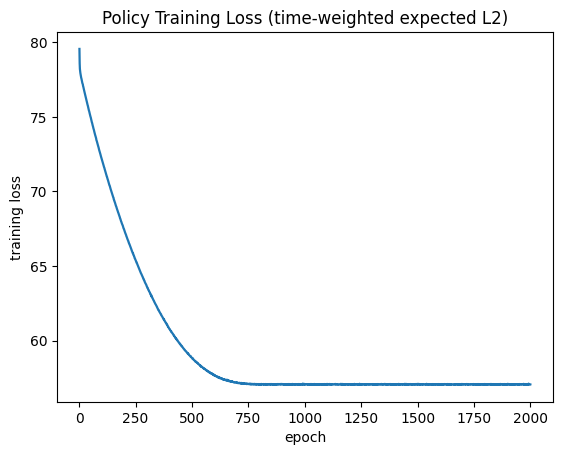

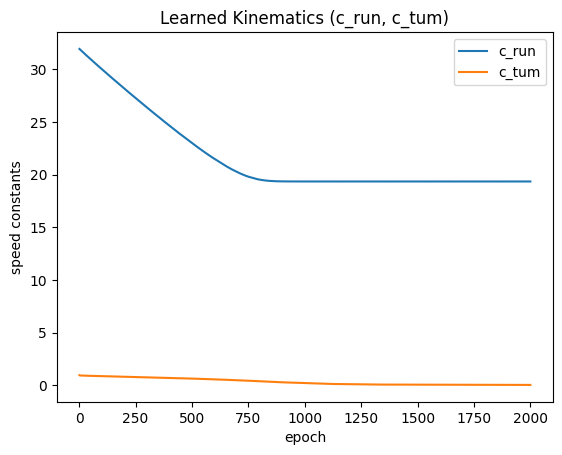

In [ ]:
# 假设你已经有 samples, n, 以及基于数据的初值 kin_init
# kin_init = {"c_run": np.nanquantile(df_use["v_speed"], 0.75), "c_tum": np.nanquantile(df_use["v_speed"], 0.25)}



# 绘图
import matplotlib.pyplot as plt
epochs = [h["epoch"] for h in hist]
losses = [h["loss"]  for h in hist]
c_run  = [h["c_run"] for h in hist]
c_tum  = [h["c_tum"] for h in hist]

plt.figure()
plt.plot(epochs, losses, linewidth=1.6)
plt.xlabel("epoch"); plt.ylabel("training loss")
plt.title("Policy Training Loss (time-weighted expected L2)")
plt.show()

plt.figure()
plt.plot(epochs, c_run, label="c_run")
plt.plot(epochs, c_tum, label="c_tum")
plt.xlabel("epoch"); plt.ylabel("speed constants")
plt.title("Learned Kinematics (c_run, c_tum)")
plt.legend(); plt.show()


In [ ]:
def export_TT_ZZ(tz, m):
    T_run = tz.T_run().detach().cpu().numpy()   # (n,n)
    T_tum = tz.T_tum().detach().cpu().numpy()   # (n,n)
    Z_nm2 = tz.Z().detach().cpu().numpy()       # (n, m^2)
    n = T_run.shape[0]
    TT_learn = np.stack([T_run, T_tum], axis=0) # (2,n,n)
    ZZ_learn = Z_nm2.reshape(n, m, m).transpose(1,2,0)  # (m,m,n)
    return TT_learn, ZZ_learn



TT_learn, ZZ_learn = export_TT_ZZ(tz, m)
TT_learn,ZZ_learn=torch.tensor(TT_learn),torch.tensor(ZZ_learn)
print("TT_learn:", TT_learn.shape, "ZZ_learn:", ZZ_learn.shape)  # (2,n,n), (m,m,n)

env_new = Env(geom=geom, src=src, sensor=sensor, TT=TT_learn, ZZ=ZZ_learn)  # 若 Env 期望 numpy，这样最稳


TT_learn: torch.Size([2, 5, 5]) ZZ_learn: torch.Size([2, 2, 5])


## IRL

listed the MI term here but didn't used the curiosity term

In [ ]:

def mutual_information(b: torch.Tensor, ZZ: torch.Tensor) -> torch.Tensor:
    """
    b: (n,) torch tensor (belief / prior)
    ZZ: either (m,m,n) or (m*m,n) emission matrix (columns sum to 1)
    returns: scalar torch tensor
    """
    # 统一 dtype/device 到 ZZ
    b = b.to(dtype=ZZ.dtype, device=ZZ.device)

    # 展平成 (m*m, n)
    if ZZ.dim() == 3:
        m1, m2, n = ZZ.shape
        Z = ZZ.reshape(m1*m2, n)
    else:
        Z = ZZ
        n = Z.shape[1]

    # 列归一（保险）
    Z = Z / torch.clamp(Z.sum(dim=0, keepdim=True), min=1e-12)

    # 边缘 o = Z b
    o = Z @ b  # (m*m,)


    # term = sum_h b_h sum_v Z[v,h] log Z[v,h] - sum_v o_v log o_v
    logZ = torch.log(torch.clamp(Z, min=1e-12))
    col_term = (Z * logZ).sum(dim=0)        # (n,)
    term2 = (b * col_term).sum() - (o * torch.log(torch.clamp(o, min=1e-12))).sum()
    return term2

In [ ]:
import torch, numpy as np

# ---------- 工具：从观测 index 得到后验 b(o) ----------
def build_B_from_observations(samples, ZZ_torch, m, device=None, dtype=torch.float32):
    """
    ZZ_torch: (m*m, n) 列归一；samples 含 'o_idx'
    返回 B: (T, n)，每行是 b(o_t) ∝ Z[o_t,:]
    """
    T = len(samples)
    idx = torch.tensor([s["o_idx"] for s in samples], dtype=torch.long, device=device)
    Z_o = ZZ_torch.index_select(0, idx)               # (T, n)
    B = Z_o / (Z_o.sum(dim=1, keepdim=True).clamp_min(1e-12))
    return B

# ---------- 批量互信息 I(B; Z)（可选好奇心） ----------
def batched_mutual_information(B, ZZ):
    """
    B:  (T, n)  posterior beliefs
    ZZ: (m*m, n) emission (cols sum to 1)
    返回: I(B;Z) 形状 (T,)
    """
    Z = ZZ
    logZ = torch.log(Z.clamp_min(1e-12))
    col_term = (Z * logZ).sum(dim=0)                 # (n,)
    t1 = (B * col_term.unsqueeze(0)).sum(dim=1)      # (T,)
    O = (Z @ B.T).T                                  # (T, m*m)
    t2 = (O * torch.log(O.clamp_min(1e-12))).sum(dim=1)
    return t1 - t2                                   # (T,)

# ---------- 关键改动：专家概率来自“数据”，不是来自已学策略 ----------
def collect_expert_probs_from_data(samples, m, device=None, dtype=torch.float32,
                                   mode="bin", alpha=1.0):
    """
    返回 P_exp: (T,2) = [p_run, p_tum] 作为“专家”分布。
    两种模式：
      - mode='sample'：逐样本 one-hot（需 samples[i]['a'] ∈ {0,1}）
      - mode='bin' ：按观测 o_idx 汇总计数 + 拉普拉斯平滑，得到 π
        然后回填到每个样本
    alpha: 拉普拉斯平滑强度（bin 模式）
    """
    T = len(samples)
    idx = torch.tensor([s["o_idx"] for s in samples], dtype=torch.long, device=device)
    if mode == "sample":
        if "a" not in samples[0]:
            raise ValueError("mode='sample' 需要 samples 含二元标签 'a'")
        a = torch.tensor([float(s["a"]) for s in samples], dtype=dtype, device=device)
        p_tum = torch.clamp(a, 1e-6, 1-1e-6)
        P_exp = torch.stack([1.0 - p_tum, p_tum], dim=1)
        return P_exp

    # mode == 'bin'：对每个观测 o_idx 统计 run/tum 频率并平滑
    mm = m*m
    # 若没有显式标签 a，可从原 df 的 action_id 对齐到窗口；否则要求 samples 有 'a'
    if "a" in samples[0]:
        a_np = np.array([float(s["a"]) for s in samples], float)
        a = torch.tensor(a_np, dtype=dtype, device=device)
        counts = torch.zeros(mm, 2, dtype=dtype, device=device)  # [:,0]=run, [:,1]=tumble
        # 累计计数
        for k in range(T):
            oi = int(idx[k])
            ak = int(a[k].item() >= 0.5)
            counts[oi, ak] += 1.0
    else:
        raise ValueError("为了用 mode='bin' 汇总专家，需要 samples 含 'a' 或你自行构造每桶计数。")

    # 拉普拉斯平滑
    denom = counts.sum(dim=1, keepdim=True) + 2*alpha
    p_tum_o = (counts[:, 1] + alpha) / denom.squeeze(1)          # (mm,)
    p_tum = p_tum_o.index_select(0, idx)                         # (T,)
    p_tum = torch.clamp(p_tum, 1e-6, 1-1e-6)
    P_exp = torch.stack([1.0 - p_tum, p_tum], dim=1)             # (T,2)
    return P_exp

# ---------- IRL：用“数据专家”学 r ----------
def train_irl_reward_from_obs_data(samples, env,
                                   r0, m, tau=1.0, curiosity=0.0,
                                   lr=5e-2, epochs=200, lambda_r=1e-3,
                                   expert_mode="bin", alpha=1.0,    # 专家概率构造方式
                                   time_weight=False,               # 是否用 dt 作为样本权重
                                   device=None):
    """
    与你原来的 train_irl_reward_from_obs 类似，但专家分布 P_exp 来自“数据”，不再来自 policy。
    - expert_mode='sample'：逐样本 one-hot
    - expert_mode='bin'：按观测桶平滑（推荐，稳健）
    """
    # ----- ZZ -> (m*m, n)
    if isinstance(env.ZZ, np.ndarray):
        ZZ = torch.tensor(env.ZZ, dtype=torch.float32, device=device)
    else:
        ZZ = env.ZZ.to(device=device, dtype=torch.float32)
    if ZZ.dim() == 3:
        mm, mm2, n_states = ZZ.shape
        ZZ = ZZ.reshape(mm*mm2, n_states)
    else:
        n_states = ZZ.shape[1]
    ZZ = ZZ / ZZ.sum(dim=0, keepdim=True).clamp_min(1e-12)   # 列归一（保险）

    # ----- TT -> (A, n, n)
    if isinstance(env.TT, np.ndarray):
        TT = torch.tensor(env.TT, dtype=torch.float32, device=device)
    else:
        TT = env.TT.to(device=device, dtype=torch.float32)
    A = TT.shape[0]
    n = TT.shape[1]

    # ----- 奖励参数 r
    r = torch.nn.Parameter(torch.tensor(r0, dtype=torch.float32, device=device))
    opt = torch.optim.Adam([r], lr=lr)

    # ----- 构造：b(o_t) 与“数据专家” P_exp
    B = build_B_from_observations(samples, ZZ, m, device=device)  # (T, n)
    P_exp = collect_expert_probs_from_data(samples, m, device=device,
                                           dtype=torch.float32, mode=expert_mode, alpha=alpha)  # (T,2)

    # 可选：时间权重
    if time_weight:
        W = torch.tensor([float(s["dt"]) for s in samples], dtype=torch.float32, device=device)
        W = W / W.sum()
    else:
        W = None

    hist=[]
    for ep in range(1, epochs+1):
        opt.zero_grad()

        # ---- 计算 Q_r(o,a)（批量）
        Qs = []
        for a_idx in range(A):
            Tb = (TT[a_idx] @ B.T).T                       # (T,n)
            term1 = (r * Tb).sum(dim=1)                    # (T,)
            if curiosity > 0.0:
                mi = batched_mutual_information(Tb, ZZ)    # (T,)
                Qa = term1 + curiosity * mi
            else:
                Qa = term1
            Qs.append(Qa)
        Q = torch.stack(Qs, dim=1)                         # (T,A)

        # 软策略（由 r 决定）
        P_r = torch.softmax(Q / float(tau), dim=1)         # (T, A)

        # ---- 交叉熵（最大似然） + L2 正则
        ce = - (P_exp * torch.log(P_r.clamp_min(1e-12))).sum(dim=1)  # (T,)
        if W is not None:
            loss = (W * ce).sum() + lambda_r * (r*r).sum()
        else:
            loss = ce.mean() + lambda_r * (r*r).sum()

        loss.backward()
        opt.step()

        rec = dict(epoch=ep, loss=float(loss.item()))
        hist.append(rec)
        if ep==1 or ep%50==0:
            print(f"[IRL-obs DATA ep {ep:03d}] J={rec['loss']:.4e}")

    return r.detach().cpu().numpy(), hist


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# r 初值
r0 = np.zeros(n, dtype=np.float32)
r0[0] = 10.0
r0[1] = r0[-1] = 8.0

# 用“观测桶 + 拉普拉斯平滑”的专家分布（稳健），并可选按 dt 加权样本
r_star, irl_hist = train_irl_reward_from_obs_data(
    samples, env=env_new,
    r0=r0, m=m, tau=1.0, curiosity=0.0,
    lr=5e-2, epochs=1000, lambda_r=1e-3,
    expert_mode="bin", alpha=1.0,
    time_weight=False,            # 若样本 dt 不均匀且想做时间加权，可设 True
    device=device
)
print("Learned reward r:", r_star)


[IRL-obs DATA ep 001] J=1.0142e+00
[IRL-obs DATA ep 050] J=8.4215e-01
[IRL-obs DATA ep 100] J=7.6338e-01
[IRL-obs DATA ep 150] J=7.2348e-01
[IRL-obs DATA ep 200] J=7.0430e-01
[IRL-obs DATA ep 250] J=6.9628e-01
[IRL-obs DATA ep 300] J=6.9340e-01
[IRL-obs DATA ep 350] J=6.9251e-01
[IRL-obs DATA ep 400] J=6.9228e-01
[IRL-obs DATA ep 450] J=6.9223e-01
[IRL-obs DATA ep 500] J=6.9222e-01
[IRL-obs DATA ep 550] J=6.9221e-01
[IRL-obs DATA ep 600] J=6.9221e-01
[IRL-obs DATA ep 650] J=6.9221e-01
[IRL-obs DATA ep 700] J=6.9221e-01
[IRL-obs DATA ep 750] J=6.9221e-01
[IRL-obs DATA ep 800] J=6.9221e-01
[IRL-obs DATA ep 850] J=6.9221e-01
[IRL-obs DATA ep 900] J=6.9221e-01
[IRL-obs DATA ep 950] J=6.9221e-01
[IRL-obs DATA ep 1000] J=6.9221e-01
Learned reward r: [ 0.07092752 -0.28374606  0.07092735  0.07092735  0.07092707]


### simulation with learned policy

In [ ]:
import numpy as np, torch, matplotlib.pyplot as plt



# --- 从奖励 r^* + (T,Z) 构造软策略 π_r(a|b)
def policy_from_reward(r_star, TT, ZZ, tau=1.0, curiosity=0.0):
    r_t = torch.tensor(r_star, dtype=torch.float64)
    def f(b_np):
        # Cast belief state to float32 to match TT's likely dtype
        b = torch.tensor(b_np, dtype=torch.float32)
        Qa = []
        for a in range(TT.shape[0]):
            # Ensure TT slice has consistent dtype with b
            Tb = TT[a].to(dtype=torch.float32) @ b
            term1 = (r_t.to(dtype=torch.float32) * Tb).sum() # Ensure r_t also matches dtype
            if curiosity != 0.0:
                # mutual_information needs consistent dtypes, potentially needs similar casting
                term2 = mutual_information(Tb, ZZ.to(dtype=torch.float32))
            else:
                term2 = torch.tensor(0.0, dtype=torch.float32)
            Qa.append((term1 + curiosity*term2)/tau)
        P = torch.softmax(torch.stack(Qa), dim=0)  # (2,)
        return float(P[1])                         # P(tumble)
    return f
def _normalize(v, eps=1e-12):
    v = np.asarray(v, float)
    n = np.linalg.norm(v) + eps
    return v / n

# 正确的 belief 更新： b_{t+1} ∝ Z[o|h] ⊙ (T_a b_t)
def pomdp_update(b, a, o, TT, ZZ):
    # b: torch (n,), a∈{0,1}, o=(oL,oR), TT:(2,n,n), ZZ:(m,m,n)
    Tb   = b                                  # (n,)
    like = ZZ[o[0], o[1], :].clamp_min(1e-12)         # (n,)
    post = like * Tb
    return post / post.sum().clamp_min(1e-12)

# --- 用（c_run, c_tum）一步推进（含小随机扰动）
def kinematics_step(x, v, a, dt, c_run, c_tum, rng, turn_noise_std=0.05):
    if a == 0:  # run
        u = v / (np.linalg.norm(v) + 1e-12)
        # 小角度噪声，让轨迹更自然
        ang = rng.normal(0.0, turn_noise_std)
        R = np.array([[np.cos(ang), -np.sin(ang)], [np.sin(ang), np.cos(ang)]])
        u = R @ u
        v_new = c_run * u
    else:       # tumble
        phi = rng.uniform(0, 2*np.pi)
        u = np.array([np.cos(phi), np.sin(phi)])
        v_new = c_tum * u
    x_new = x + dt * v_new
    return x_new, v_new

In [ ]:
# belief 驱动的 POMDP 仿真：用 π_r(b) 选动作
def simulate_pomdp(env, policy_fn, kin, steps=800, dt=0.125, seed=0, x0=None, random=False):
    """
    env 需有: env.TT(torch 2,n,n), env.ZZ(torch m,m,n), env.src['mu'], env.geom/src/sensor, observation_biophysical 可用
    policy_fn: b(np.ndarray n,) -> P(tumble)
    kin: dict(c_run=?, c_tum=?)
    """
    rng = np.random.default_rng(seed)
    n = env.TT.shape[1]; m = env.ZZ.shape[0]

    if random:
        x = rng.uniform(-2, 2, size=2).astype(float) if x0 is None else np.array(x0, float)
    else:
        x = np.array([0.0, 0.0], float) if x0 is None else np.array(x0, float)
    v = _normalize(env.src['mu'] - x)

    b = np.ones(n, float)/n
    traj=[x.copy()]; acts=[]; vlist=[v.copy()]; bels=[b.copy()]
    o = observation_biophysical(x, env.src["mu"], v, n, m, env.geom, env.src, env.sensor)
    a=0

    for _ in range(steps):
        # 用当前 belief 选动作
        b_torch = torch.tensor(b, dtype=torch.float32)
        b = pomdp_update(b_torch, a, o, env.TT.to(dtype=torch.float32), env.ZZ.to(dtype=torch.float32)).cpu().numpy()
        p_tum = policy_fn(b)
        a = 1 if rng.random() < p_tum else 0

        # 推进环境到 t+1
        x, v = kinematics_step(x, v, a, dt, kin["c_run"], kin["c_tum"], rng)

        # 生成新观测，并更新 belief
        o = observation_biophysical(x, env.src["mu"], v, n, m, env.geom, env.src, env.sensor)


        # 记录
        traj.append(x.copy()); acts.append(a); vlist.append(v.copy()); bels.append(b.copy())

    return np.array(traj), np.array(acts), np.array(bels), np.array(vlist[1:])

In [ ]:
def plot_trajectory(traj, actions=None, src_mu=None, title="Simulated trajectory"):
    plt.figure(figsize=(5.2,5.2))
    if actions is None:
        plt.plot(traj[:,0], traj[:,1], '-', lw=1.5, alpha=0.9)
    else:
        # 按动作配色：run=蓝，tumble=橙
        colors = np.where(actions==1, "orange", "steelblue")
        # Plot points from the second point onwards to match the length of actions
        plt.scatter(traj[1:,0], traj[1:,1], c=colors, s=8)
        plt.plot(traj[:,0], traj[:,1], alpha=0.4, color="#666666")
        handles = [plt.Line2D([0],[0], marker='o', color='w', label='run',    markerfacecolor='steelblue', markersize=6),
                   plt.Line2D([0],[0], marker='o', color='w', label='tumble', markerfacecolor='orange',    markersize=6)]
        plt.legend(handles=handles, loc="best")
    plt.scatter(traj[0,0], traj[0,1], c='g', s=50, label="start")
    plt.scatter(traj[-1,0], traj[-1,1], c='black', s=50, label="end")
    if src_mu is not None:
        plt.scatter(src_mu[0], src_mu[1], marker='*', s=130, c='red', label='light')
    plt.axis('equal'); plt.title(title); plt.xlabel("x"); plt.ylabel("y"); plt.grid(alpha=0.2)
    plt.legend(loc="best")
    plt.show()

/tmp/ipython-input-681454241.py:1: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  kin_sim   = {"c_run": float(kin()[0]), "c_tum": float(kin()[1])}


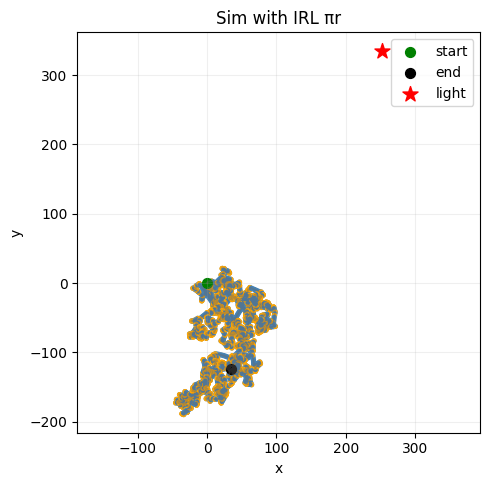

In [ ]:
kin_sim   = {"c_run": float(kin()[0]), "c_tum": float(kin()[1])}

pi_r = policy_from_reward(r_star, env_new.TT, env_new.ZZ, tau=1.0, curiosity=0.0)
traj, acts, bels, vlist= simulate_pomdp(env_new, pi_r, kin_sim, steps=4000, dt=dt_policy, seed=0)
plot_trajectory(traj, acts, src_mu=env_new.src["mu"], title="Sim with IRL πr")

对比policy和pi_r

In [ ]:
import numpy as np, torch


# --- Phase-1 策略的仿真（观测驱动）
@torch.no_grad()
def simulate_pomdp_with_hazard(env, policy_obs, kin, steps=800, dt=0.125, seed=0, device=None):
    """
    policy_obs: HazardPolicyObs（forward(O, DT) -> (p_tum, h)）
    返回: traj (T+1,2), acts (T,), bels (T+1,n), vlist (T,2)
    """
    device = device or (next(policy_obs.parameters()).device if hasattr(policy_obs, "parameters") else torch.device("cpu"))
    rng = np.random.default_rng(seed)
    n = env.TT.shape[1]
    m = env.ZZ.shape[0]  # 假设 ZZ 形状 (m,m,n)

    # 初始位置朝向（与你现有保持一致）
    x = np.array([0.0, 0.0], float)
    v = (env.src['mu'] - x); v = v / (np.linalg.norm(v) + 1e-12)

    # 初始 belief 均匀（可选）
    b = np.ones(n, float) / n

    # 初始观测
    o = observation_biophysical(x, env.src["mu"], v, n, m, env.geom, env.src, env.sensor)

    traj=[x.copy()]; acts=[]; vlist=[v.copy()]; bels=[b.copy()]
    a_prev = 0  # 用于 belief 更新

    for _ in range(steps):
        # 1) （可选）belief 更新（保持与你 IRL 仿真一致）
        b_t = torch.tensor(b, dtype=torch.float32, device=device)
        TTf = env.TT.to(device=device, dtype=torch.float32)
        ZZf = env.ZZ.to(device=device, dtype=torch.float32)
        b = pomdp_update(b_t, a_prev, o, TTf, ZZf).cpu().numpy()

        # 2) Phase-1 策略：用当前观测的 one-hot 计算 p_tum
        O = torch.zeros(1, m*m, dtype=torch.float32, device=device)
        o_idx = int(o[0]) * m + int(o[1])
        O[0, o_idx] = 1.0
        DT = torch.tensor([dt], dtype=torch.float32, device=device)
        p_tum, _ = policy_obs(O, DT)           # (1,)
        p_tum = float(torch.clamp(p_tum, 1e-6, 1-1e-6).item())

        # 3) 采样动作、推进运动学
        a = 1 if rng.random() < p_tum else 0
        x, v = kinematics_step(x, v, a, dt, kin["c_run"], kin["c_tum"], rng)

        # 4) 生成下一时刻观测
        o = observation_biophysical(x, env.src["mu"], v, n, m, env.geom, env.src, env.sensor)

        # 5) 记录
        traj.append(x.copy()); acts.append(a); vlist.append(v.copy()); bels.append(b.copy())
        a_prev = a

    return np.array(traj), np.array(acts), np.array(bels), np.array(vlist[1:])


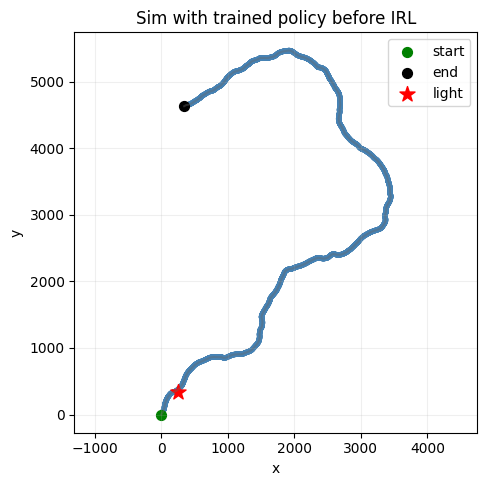

[Phase-1 policy] tumbles=0/4000  frac=0.0000


In [ ]:
# 来自 Phase-1 的模型与参数
policy_obs = policy.eval()                # 你 train_policy_obs_batched_TZ 返回的 policy
# kin_sim    = {"c_run": float(kin()[0]), "c_tum": float(kin()[1])}

# Phase-1 策略仿真
traj_p1, acts_p1, bels_p1, vlist_p1 = simulate_pomdp_with_hazard(
    env_new, policy_obs, kin_sim, steps=4000, dt=dt_policy, seed=0
)
plot_trajectory(traj_p1,acts_p1,src_mu=env_new.src["mu"], title="Sim with trained policy before IRL")

# tumble 比例
p_p1 = (acts_p1 == 1).mean()
print(f"[Phase-1 policy] tumbles={acts_p1.sum()}/{acts_p1.size}  frac={p_p1:.4f}")


### tumbling ratio

In [ ]:
import numpy as np

# acts2: 形如 [0,1,0,0,1,...]，长度应为 traj.shape[0]-1
K_sim = int(np.count_nonzero(acts == 1))   # tumble 次数
N_sim = int(acts.size)                     # 区间总数
p_sim = K_sim / N_sim if N_sim > 0 else float('nan')

print(f"[SIM] tumbles={K_sim}/{N_sim}  frac={p_sim:.3f}")


[SIM] tumbles=1940/4000  frac=0.485


In [ ]:
import pandas as pd

df=df_grid



# 丢掉每条轨迹的第一行 NaN（我们把区间动作写在“下一行”）
df = df[df["a"].notna()].copy()
df["a"] = df["a"].astype(int)

# —— 全局 —— #
K_real = int((df["a"] == 1).sum())
N_real = int(len(df))
# p_real = K_real / N_real if N_real > 0 else float('nan')
# print(f"[REAL] tumbles={K_real}/{N_real}  frac={p_real:.3f}")

# —— 按 cell_id —— #
per_cell = (
    df.sort_values(["cell_id","t_start"])
          .groupby("cell_id")["a"]
          .agg(n_intervals="size",
               n_tumble=lambda s: int((s==1).sum()),
               tumble_frac=lambda s: float((s==1).mean()))
          .reset_index()
)
p_real=per_cell["tumble_frac"].mean()

print(per_cell)
print(f"[REAL] tumble frac={p_real:.3f}")


    cell_id  n_intervals  n_tumble  tumble_frac
0         0          717        12     0.016736
1         1          699        14     0.020029
2         2          874         5     0.005721
3         3          652         5     0.007669
4         4          625        10     0.016000
5         5         1021        62     0.060725
6         6          870        14     0.016092
7         7          548         3     0.005474
8         8          556         3     0.005396
9         9          576         4     0.006944
10       10          567         3     0.005291
11       11          606         5     0.008251
12       12          522         5     0.009579
13       13          788         3     0.003807
14       14          600         6     0.010000
15       15          884         4     0.004525
16       16          637        14     0.021978
17       17          622        10     0.016077
18       18          601         3     0.004992
19       19          586         4     0

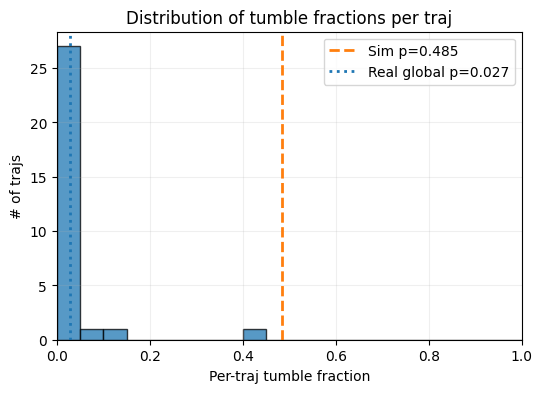

In [ ]:
vals = per_cell["tumble_frac"].dropna().to_numpy()
bins = np.linspace(0, 1, 21)

plt.figure(figsize=(6,4))
plt.hist(vals, bins=bins, alpha=0.75, edgecolor="k")
plt.axvline(p_sim, color="C1", ls="--", lw=2, label=f"Sim p={p_sim:.3f}")
plt.axvline(p_real, color="C0", ls=":",  lw=2, label=f"Real global p={p_real:.3f}")
plt.xlabel("Per-traj tumble fraction")
plt.ylabel("# of trajs")
plt.title("Distribution of tumble fractions per traj")
plt.legend()
plt.xlim(0,1)
plt.grid(alpha=0.2)
plt.show()

In [ ]:
# ---------- alignment（cos）与直方图 ----------
def alignment_cos_from_traj(traj, vlist, mu, eps=1e-9):
    # 忽略第一步速度 NaN 的情况：这里假设 vlist 与 traj 对齐
    u = vlist / (np.linalg.norm(vlist, axis=1, keepdims=True) + eps)           # (T+1,2)
    d = (np.asarray(mu, float) - traj)
    d = d / (np.linalg.norm(d, axis=1, keepdims=True) + eps)
    cosv = np.sum(u * d, axis=1)                                              # (T+1,)
    return cosv

def alignment_cos_from_df(df, mu, group="cell_id"):
    out=[]
    for cid, g in df.sort_values([group,"t_start"]).groupby(group):
        g = g[g["dt"]>0]
        if len(g)==0: continue
        v = g[["vx0","vy0"]].to_numpy()
        x = g[["x0","y0"]].to_numpy()
        u = v / (np.linalg.norm(v, axis=1, keepdims=True) + 1e-9)
        d = (np.asarray(mu,float) - x)
        d = d / (np.linalg.norm(d, axis=1, keepdims=True) + 1e-9)
        cosv = np.sum(u*d, axis=1)
        cosv = cosv[np.isfinite(cosv)]
        out.append(cosv)
    return np.concatenate(out) if len(out)>0 else np.array([])

def plot_alignment_hist(sim_cos, data_cos, bins=30, title="Alignment (cos)"):
    plt.figure(figsize=(6,4))
    plt.hist(data_cos, bins=bins, range=(-1,1), alpha=0.5, density=True, label="data")
    plt.hist(sim_cos,  bins=bins, range=(-1,1), alpha=0.5, density=True, label="simulation")
    plt.xlabel("cos(angle to light)"); plt.ylabel("density"); plt.title(title)
    plt.legend(); plt.grid(alpha=0.2); plt.show()

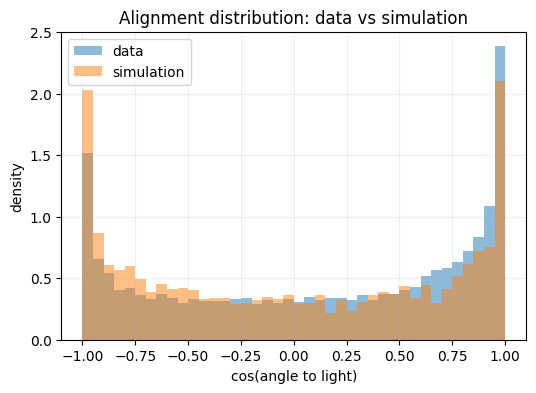

In [ ]:
sim_cos = alignment_cos_from_traj(traj[1:], vlist, np.asarray(env_new.src["mu"]))
# 真实数据的 alignment（df 已有 vx,vy,x,y,dt_sec）
data_cos = alignment_cos_from_df(df, np.asarray(env_new.src["mu"]))

plot_alignment_hist(sim_cos, data_cos, bins=40, title="Alignment distribution: data vs simulation")


n_data              2.042000e+04
n_sim               4.000000e+03
KS_D                8.930803e-02
KS_p                1.153226e-23
W1                  1.320301e-01
JS                  6.705888e-03
hist_L1             1.968908e-01
E_cos_data          1.254070e-01
E_cos_sim          -6.600738e-03
P(cos>0.8)_data     2.512733e-01
P(cos>0.8)_sim      2.097500e-01
P(cos<-0.8)_data    1.562684e-01
P(cos<-0.8)_sim     2.035000e-01
dtype: float64

CIs (bootstrap 95%):
KS_D   in [0.077, 0.108]
W1     in [0.109, 0.155]
JS     in [0.006, 0.010]
hist_L1 in [0.184, 0.240]


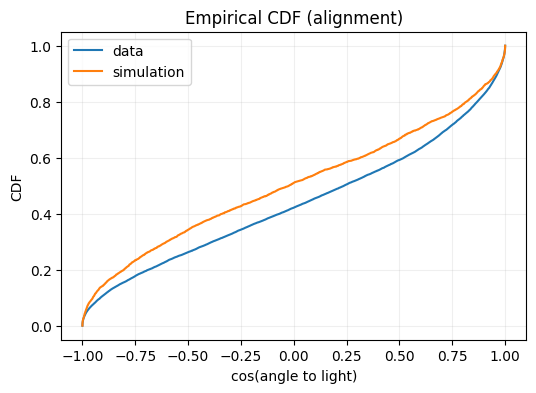

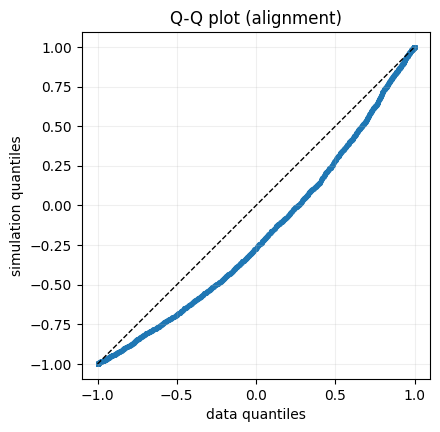

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, wasserstein_distance, entropy
import matplotlib.pyplot as plt


def js_divergence(x, y, bins=40, rng=(-1,1), eps=1e-12):
    # 直方图密度（归一化）
    px, _ = np.histogram(x, bins=bins, range=rng, density=True)
    py, _ = np.histogram(y, bins=bins, range=rng, density=True)
    px = px / (px.sum() + eps)
    py = py / (py.sum() + eps)
    m  = 0.5*(px+py)
    return 0.5*entropy(px+eps, m+eps) + 0.5*entropy(py+eps, m+eps)

def hist_L1(x, y, bins=40, rng=(-1,1)):
    px, _ = np.histogram(x, bins=bins, range=rng, density=True)
    py, _ = np.histogram(y, bins=bins, range=rng, density=True)
    # 乘以 bin width 得到“密度差的总面积”
    width = (rng[1]-rng[0])/bins
    return np.abs(px - py).sum() * width

def tail_probs(z, thr=0.8):
    z = z[np.isfinite(z)]
    return (np.mean(z > +thr), np.mean(z < -thr))

def summarize_alignment(sim_cos, data_cos, bins=40, rng=(-1,1)):
    sim = sim_cos[np.isfinite(sim_cos)]
    dat = data_cos[np.isfinite(data_cos)]
    # 效果量
    ks = ks_2samp(dat, sim, alternative='two-sided', mode='auto')
    w1 = wasserstein_distance(dat, sim)               # [-1,1] 上的距离，越小越好
    js = js_divergence(dat, sim, bins=bins, rng=rng)  # 0~ln2
    l1 = hist_L1(dat, sim, bins=bins, rng=rng)        # 0~2（最多密度完全不重叠）
    # 关键行为
    p_plus_dat, p_minus_dat = tail_probs(dat, 0.8)
    p_plus_sim, p_minus_sim = tail_probs(sim, 0.8)
    return {
        "n_data": len(dat), "n_sim": len(sim),
        "KS_D": ks.statistic, "KS_p": ks.pvalue,
        "W1": w1, "JS": js, "hist_L1": l1,
        "E_cos_data": float(np.mean(dat)), "E_cos_sim": float(np.mean(sim)),
        "P(cos>0.8)_data": p_plus_dat, "P(cos>0.8)_sim": p_plus_sim,
        "P(cos<-0.8)_data": p_minus_dat, "P(cos<-0.8)_sim": p_minus_sim,
    }

# Bootstrap 置信区间
def bootstrap_ci(fn, x, y, B=1000, alpha=0.05, random_state=0):
    rng = np.random.default_rng(random_state)
    vals = []
    n, m = len(x), len(y)
    for _ in range(B):
        xb = x[rng.integers(0, n, n)]
        yb = y[rng.integers(0, m, m)]
        vals.append(fn(xb, yb))
    lo = np.percentile(vals, 100*alpha/2)
    hi = np.percentile(vals, 100*(1-alpha/2))
    return float(lo), float(hi)

# 汇总 + 置信区间
res = summarize_alignment(sim_cos, data_cos, bins=40)
ks_ci = bootstrap_ci(lambda a,b: ks_2samp(a,b).statistic, data_cos, sim_cos)
w1_ci = bootstrap_ci(lambda a,b: wasserstein_distance(a,b), data_cos, sim_cos)
js_ci = bootstrap_ci(lambda a,b: js_divergence(a,b, bins=40), data_cos, sim_cos)
l1_ci = bootstrap_ci(lambda a,b: hist_L1(a,b, bins=40), data_cos, sim_cos)

print(pd.Series(res))
print("\nCIs (bootstrap 95%):")
print(f"KS_D   in [{ks_ci[0]:.3f}, {ks_ci[1]:.3f}]")
print(f"W1     in [{w1_ci[0]:.3f}, {w1_ci[1]:.3f}]")
print(f"JS     in [{js_ci[0]:.3f}, {js_ci[1]:.3f}]")
print(f"hist_L1 in [{l1_ci[0]:.3f}, {l1_ci[1]:.3f}]")

# 可选：CDF / QQ 可视化
def plot_cdf_compare(x, y, title="Empirical CDF (alignment)"):
    xs = np.sort(x[np.isfinite(x)])
    ys = np.sort(y[np.isfinite(y)])
    Fx = np.arange(1,len(xs)+1)/len(xs)
    Fy = np.arange(1,len(ys)+1)/len(ys)
    plt.figure(figsize=(6,4))
    plt.plot(xs, Fx, label="data")
    plt.plot(ys, Fy, label="simulation")
    plt.xlabel("cos(angle to light)"); plt.ylabel("CDF"); plt.title(title)
    plt.grid(alpha=0.2); plt.legend(); plt.show()

def plot_qq_compare(x, y, title="Q-Q plot (alignment)"):
    xs = np.sort(x[np.isfinite(x)]); ys = np.sort(y[np.isfinite(y)])
    k = min(len(xs), len(ys))
    xs = xs[np.linspace(0,len(xs)-1,k).astype(int)]
    ys = ys[np.linspace(0,len(ys)-1,k).astype(int)]
    plt.figure(figsize=(4.5,4.5))
    plt.scatter(xs, ys, s=6, alpha=0.6)
    lim = [-1,1]; plt.plot(lim, lim, 'k--', lw=1)
    plt.xlabel("data quantiles"); plt.ylabel("simulation quantiles")
    plt.title(title); plt.grid(alpha=0.2); plt.axis('equal'); plt.show()

plot_cdf_compare(data_cos, sim_cos)
plot_qq_compare(data_cos, sim_cos)


todo:

可以区分动作kan是否align

可以随机取初始点多simulate几条数据然后跟gillespie作为benchmark进行对比

修改之前的公式，再次明确算法流程

# compare with Gillespie(benchmark)

##
simulate more trajs(30) with learned policy

In [ ]:

N=30
policy_trajs=[]
for i in range(N):
  traj, acts, bels, vlist= simulate_pomdp(env_new, pi_r, kin_sim, random=False,steps=4000, dt=dt_policy, seed=1000+i)
  run_id = np.full(len(traj), i, int)
  step_id = np.arange(len(traj))
  acts=[0]+acts.tolist()

  df_one = pd.DataFrame(dict(run_id=run_id, step=step_id, x=traj[:, 0], y=traj[:, 1], action=acts,dt=dt_policy))
  policy_trajs.append(df_one)

df_policy = pd.concat(policy_trajs, ignore_index=True)
df_policy.to_csv("./trajs_policy.csv", index=False)

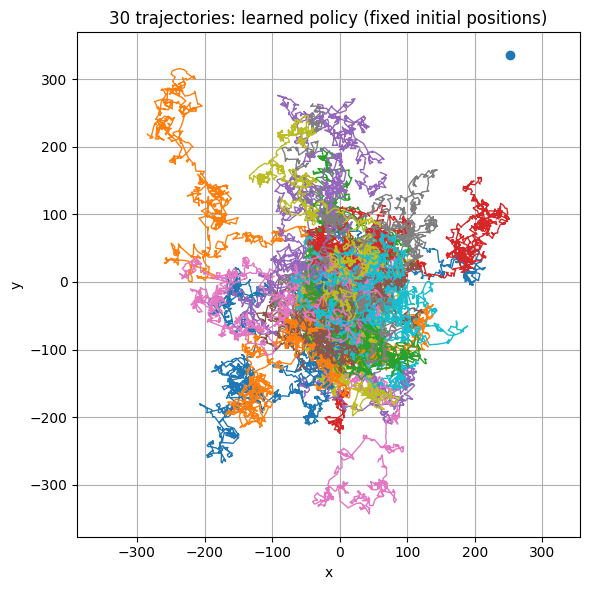

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(N):
    dfi = df_policy[df_policy.run_id == i]
    plt.plot(dfi.x.values, dfi.y.values, linewidth=1.0)
plt.scatter([light_xy[0]], [light_xy[1]])
plt.title("30 trajectories: learned policy (fixed initial positions)")
plt.xlabel("x"); plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.savefig("./fig_trajectories_policy.png", dpi=160)
plt.show()

In [ ]:
import pandas as pd
from IPython.display import display # Import display


sum_pol = df_policy.groupby('run_id').apply(
    lambda g: pd.Series(dict(
        method='policy',
        step_ratio=float((g['action']==1).mean()),
        time_ratio=float((g['action']*g['dt']).sum()/g['dt'].sum())
    ))
).reset_index()

# display(sum_pol) # Use the imported display function

/tmp/ipython-input-3608932827.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sum_pol = df_policy.groupby('run_id').apply(


## Gillespie（modified）

In [ ]:

import numpy as np
import pandas as pd

def _normalize(v, eps=1e-12):
    v = np.asarray(v, float)
    n = np.linalg.norm(v) + eps
    return v / n

def _alignment(x, v, mu):
    u = _normalize(v)
    s = _normalize(np.asarray(mu, float) - np.asarray(x, float))
    return float(np.clip(np.dot(u, s), -1.0, 1.0))

def simulate_gillespie_modified(
    env,kin, x0,total_time=100.0, dt_grid=0.125, seed=0,
    rt_min_max=(0.06, 0.60), gamma=1.0, lambda_tum_to_run=1.2, turn_noise_std=0.05
):
    rng = np.random.default_rng(seed)

    # init
    x = x0
    mu= env.src["mu"]
    v = _normalize(env.src["mu"] - x)

    c_run = float(kin["c_run"])
    c_tum = float(kin["c_tum"])

    state = 0  # run
    t = 0.0
    t_next_out = dt_grid

    def _lambda_rt(x, v, mu):
        align = (_alignment(x, v, mu) + 1.0) * 0.5
        lam_min, lam_max = rt_min_max
        return lam_min + (lam_max - lam_min) * ((1.0 - align) ** gamma)

    lam = _lambda_rt(x, v, mu)
    t_next_event = t + rng.exponential(1.0 / max(lam, 1e-8))
    tumble_u = None

    rows = []

    while t < total_time:
        t_end = min(t_next_out, t_next_event, total_time)
        h = t_end - t
        if h > 0:
            if state == 0:  # run
                u = _normalize(v)
                ang = rng.normal(0.0, turn_noise_std)
                c, s = np.cos(ang), np.sin(ang)
                R = np.array([[c, -s], [s, c]])
                u = R @ u
                v = c_run * u
                x = x + h * v
            else:  # tumble
                if tumble_u is None:
                    phi = rng.uniform(0, 2*np.pi)
                    tumble_u = np.array([np.cos(phi), np.sin(phi)])
                v = c_tum * tumble_u

                x = x + h * v

            t += h

            if abs(t - t_next_out) < 1e-12 or (t == total_time and t < t_next_out):
                rows.append(dict(t=t, dt=h, x=x[0], y=x[1],
                                 action=int(state),
                                 align=_alignment(x, v, mu)))
                t_next_out += dt_grid

        if abs(t - t_next_event) < 1e-12 or (t_next_event < t_next_out and t_next_event <= total_time and t == t_next_event):
            if state == 0:
                state = 1
                tumble_u = None
                lam = lambda_tum_to_run
            else:
                state = 0
                lam = _lambda_rt(x, v, mu)
            t_next_event = t + rng.exponential(1.0 / max(lam, 1e-8))

    return pd.DataFrame(rows)

In [ ]:
steps=4000
dt_grid=dt_policy
total_time=steps*dt_grid
gill_trajs_m=[]
for i in range(N):
  dfi_g_m=simulate_gillespie_modified(env_new, kin_sim, x0=np.array([0,0],dtype=float),total_time=total_time,dt_grid=dt_grid,seed=1000+i)
  dfi_g_m.insert(0, 'run_id', i)
  gill_trajs_m.append(dfi_g_m)
df_gill_m = pd.concat(gill_trajs_m, ignore_index=True)
df_gill_m.to_csv("./trajs_modified_gillespie.csv", index=False)

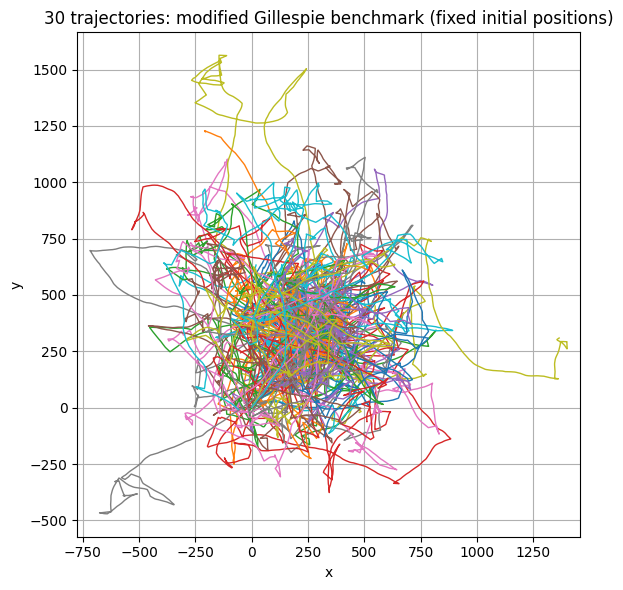

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(N):
    g_dfi_m = df_gill_m[df_gill_m.run_id == i]
    plt.plot(g_dfi_m.x.values, g_dfi_m.y.values, linewidth=1.0)
plt.scatter([light_xy[0]], [light_xy[1]])
plt.title("30 trajectories: modified Gillespie benchmark (fixed initial positions)")
plt.xlabel("x"); plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.savefig("./fig_trajectories_modified_gillespie.png", dpi=160)
plt.show()

In [ ]:
sum_gil_m= df_gill_m.groupby('run_id').apply(
    lambda g: pd.Series(dict(
        method='modified gillespie',
        step_ratio=float((g['action']==1).mean()),
        time_ratio=float((g['action']*g['dt']).sum()/g['dt'].sum())
    ))
).reset_index()

/tmp/ipython-input-3785490672.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sum_gil_m= df_gill_m.groupby('run_id').apply(


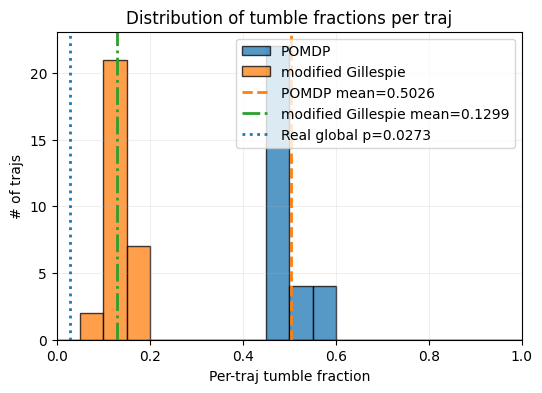

In [ ]:
vals_p= sum_pol['time_ratio'].dropna().to_numpy()
vals_gm = sum_gil_m["time_ratio"].dropna().to_numpy()
bins = np.linspace(0, 1, 21)
p_sim=vals_p.mean()
p_gm=vals_gm.mean()
p_real=per_cell["tumble_frac"].mean()
plt.figure(figsize=(6,4))
plt.hist(vals_p, bins=bins, alpha=0.75, edgecolor="k",label="POMDP")
plt.hist(vals_gm, bins=bins, alpha=0.75, edgecolor="k",label="modified Gillespie")

plt.axvline(p_sim, color="C1", ls="--", lw=2, label=f"POMDP mean={p_sim:.4f}")
plt.axvline(p_gm, color="C2", ls="-.",  lw=2, label=f"modified Gillespie mean={p_gm:.4f}")
plt.axvline(p_real, color="C0", ls=":",  lw=2, label=f"Real global p={p_real:.4f}")
plt.xlabel("Per-traj tumble fraction")
plt.ylabel("# of trajs")
plt.title("Distribution of tumble fractions per traj")
plt.legend()
plt.xlim(0,1)
plt.grid(alpha=0.2)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def alignment_from_df(df, mu_xy, vx_col='vx', vy_col='vy'):
    """
    计算 cos alignment = <v, (mu-x)> / (||v||*||mu-x||)。
    若 df 没有 vx/vy，则按 run_id 分组，用 (x,y,dt) 差分得到速度。
    返回 1D numpy 数组（已去 NaN）。
    """
    mu = np.asarray(mu_xy, float)
    df = df.copy()

    # 若没有 vx, vy，就根据 (x, y, dt) 按 run_id 做差分
    if vx_col not in df.columns or vy_col not in df.columns:
        if 'run_id' not in df.columns:
            df['run_id'] = 0
        if 'dt' not in df.columns:
            raise ValueError("当没有 vx/vy 时，df 需要包含 dt 列。")

        def _diff_vel(g):
            # 按 t 或 step 排序（你的 policy 用 step，gillespie 用 t）
            g = g.sort_values('t' if 't' in g.columns else 'step')
            x = g['x'].to_numpy(); y = g['y'].to_numpy(); dt = g['dt'].to_numpy()
            vx = np.empty_like(x); vy = np.empty_like(y)
            vx[0] = np.nan; vy[0] = np.nan
            vx[1:] = (x[1:] - x[:-1]) / dt[1:]
            vy[1:] = (y[1:] - y[:-1]) / dt[1:]
            g['vx'] = vx; g['vy'] = vy
            return g

        df = df.groupby('run_id', as_index=False, group_keys=False).apply(_diff_vel)
        vx_col, vy_col = 'vx', 'vy'

    # 计算 cos
    dx = mu[0] - df['x'].to_numpy()
    dy = mu[1] - df['y'].to_numpy()
    vxn = df[vx_col].to_numpy()
    vyn = df[vy_col].to_numpy()

    vnorm = np.sqrt(vxn**2 + vyn**2)
    snorm = np.sqrt(dx**2 + dy**2)
    valid = (vnorm > 1e-12) & (snorm > 1e-12) & np.isfinite(vnorm) & np.isfinite(snorm)

    cos_vals = np.empty_like(vnorm, dtype=float)
    cos_vals[:] = np.nan
    cos_vals[valid] = (vxn[valid]*dx[valid] + vyn[valid]*dy[valid]) / (vnorm[valid]*snorm[valid])
    cos_vals = np.clip(cos_vals, -1.0, 1.0)
    return cos_vals[~np.isnan(cos_vals)]


/tmp/ipython-input-3387512549.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('run_id', as_index=False, group_keys=False).apply(_diff_vel)
/tmp/ipython-input-3387512549.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('run_id', as_index=False, group_keys=False).apply(_diff_vel)


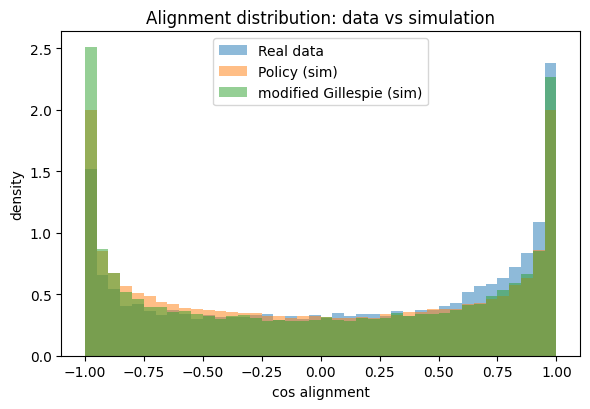

In [ ]:
# === 加载数据 ===
df_policy = pd.read_csv("./trajs_policy.csv")          # run_id, step, x, y, action, dt
# df_gill   = pd.read_csv("./trajs_modified_gillespie.csv")       # run_id, t(or step), x, y, action, dt

mu = light_xy  # ←← 填入你的光源坐标

# === 计算 alignment ===
cos_policy = alignment_from_df(df_policy, mu)
cos_gill_m   = alignment_from_df(df_gill_m,   mu)
# cos_data   = alignment_from_df(df_data,   mu, vx_col='vx', vy_col='vy')

# === 画直方图（叠加）===
plt.figure(figsize=(6,4.2))
plt.hist(data_cos,   bins=40, density=True, alpha=0.5, label='Real data')
plt.hist(cos_policy, bins=40, density=True, alpha=0.5, label='Policy (sim)')
plt.hist(cos_gill_m,   bins=40, density=True, alpha=0.5, label='modified Gillespie (sim)')
plt.xlabel('cos alignment'); plt.ylabel('density')
plt.title('Alignment distribution: data vs simulation')
plt.legend(); plt.tight_layout(); plt.show()


n_data              1.200000e+05
n_sim               1.199700e+05
KS_D                2.765505e-02
KS_p                2.715263e-40
W1                  2.630058e-02
JS                  1.719498e-03
hist_L1             9.489007e-02
E_cos_data         -3.567164e-03
E_cos_sim           1.073086e-03
P(cos>0.8)_data     2.030667e-01
P(cos>0.8)_sim      2.185046e-01
P(cos<-0.8)_data    2.041750e-01
P(cos<-0.8)_sim     2.282904e-01
dtype: float64

CIs (bootstrap 95%):
KS_D   in [0.025, 0.031]
W1     in [0.024, 0.029]
JS     in [0.002, 0.002]
hist_L1 in [0.090, 0.105]


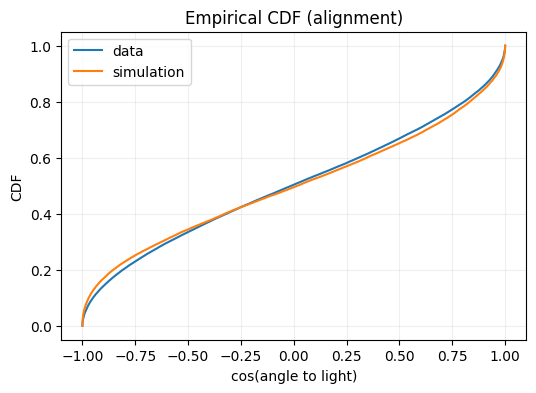

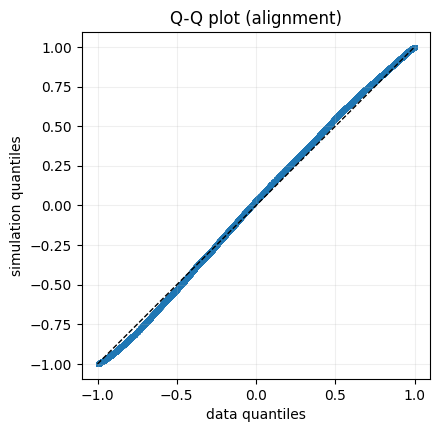

In [ ]:
res = summarize_alignment(cos_gill_m, cos_policy,bins=40)
ks_ci = bootstrap_ci(lambda a,b: ks_2samp(a,b).statistic, cos_gill_m, cos_policy)
w1_ci = bootstrap_ci(lambda a,b: wasserstein_distance(a,b), cos_gill_m, cos_policy)
js_ci = bootstrap_ci(lambda a,b: js_divergence(a,b, bins=40), cos_gill_m, cos_policy)
l1_ci = bootstrap_ci(lambda a,b: hist_L1(a,b, bins=40), cos_gill_m, cos_policy)

print(pd.Series(res))
print("\nCIs (bootstrap 95%):")
print(f"KS_D   in [{ks_ci[0]:.3f}, {ks_ci[1]:.3f}]")
print(f"W1     in [{w1_ci[0]:.3f}, {w1_ci[1]:.3f}]")
print(f"JS     in [{js_ci[0]:.3f}, {js_ci[1]:.3f}]")
print(f"hist_L1 in [{l1_ci[0]:.3f}, {l1_ci[1]:.3f}]")
plot_cdf_compare(cos_policy, cos_gill_m)
plot_qq_compare(cos_policy, cos_gill_m)

In [ ]:

import numpy as np
import pandas as pd


def simulate_gillespie(env, kin, x0, total_time=100., dt_grid=0.125,
                               rt_min_max=(0.1,1.0), gamma=1.0,
                               turn_noise_std=0.05, seed=0):
    rng = np.random.default_rng(seed)
    mu = np.asarray(env.src["mu"], float)
    c_run = float(kin["c_run"])
    x = np.array(x0, float)
    heading = _normalize(mu - x)
    t = 0.0
    t_next_out = dt_grid
    event_flag=0

    def lam_rt(x, heading):
        align = (_alignment(x, heading, mu) + 1.0) * 0.5
        lam_min, lam_max = rt_min_max
        return lam_min + (lam_max - lam_min) * ((1.0 - align) ** gamma)

    lam = lam_rt(x, heading)
    t_next_event = t + rng.exponential(1.0 / max(lam, 1e-8))

    rows = []
    while t < total_time:
        t_end = min(t_next_out, t_next_event, total_time)
        h = t_end - t

        # run 前进（可加小角噪声）
        ang = rng.normal(0.0, turn_noise_std)
        R = np.array([[np.cos(ang), -np.sin(ang)],
                      [np.sin(ang),  np.cos(ang)]])
        heading = _normalize(R @ heading)
        x = x + h * (c_run * heading)
        t += h

        # 如到达事件时刻：瞬间重定向+抽下一次
        action=0
        if abs(t - t_next_event) < 1e-12:
            phi = rng.uniform(0, 2*np.pi)
            heading = np.array([np.cos(phi), np.sin(phi)], float)
            lam = lam_rt(x, heading)
            t_next_event = t + rng.exponential(1.0 / max(lam, 1e-8))
            action=1-action
            event_flag=1

        # 到达输出网格：记录
        if abs(t - t_next_out) < 1e-12 or (t == total_time and t < t_next_out):
            rows.append(dict(
                t=t, dt=h, x=x[0], y=x[1],
                action=int(action),                # 始终 run；如需兼容旧图，可在 event==1 时写 1
                event=int(event_flag),
                align=_alignment(x, heading, mu)
            ))
            event_flag=0
            t_next_out += dt_grid

    return pd.DataFrame(rows)


In [ ]:
steps=4000
dt_grid=dt_policy
total_time=steps*dt_grid
gill_trajs=[]
for i in range(N):
  dfi_g=simulate_gillespie(env, kin_sim, x0=np.array([0,0],dtype=float),total_time=total_time,dt_grid=dt_grid,seed=1000+i)
  dfi_g.insert(0, 'run_id', i)
  gill_trajs.append(dfi_g)
df_gill = pd.concat(gill_trajs, ignore_index=True)
df_gill.to_csv("./trajs_gillespie.csv", index=False)

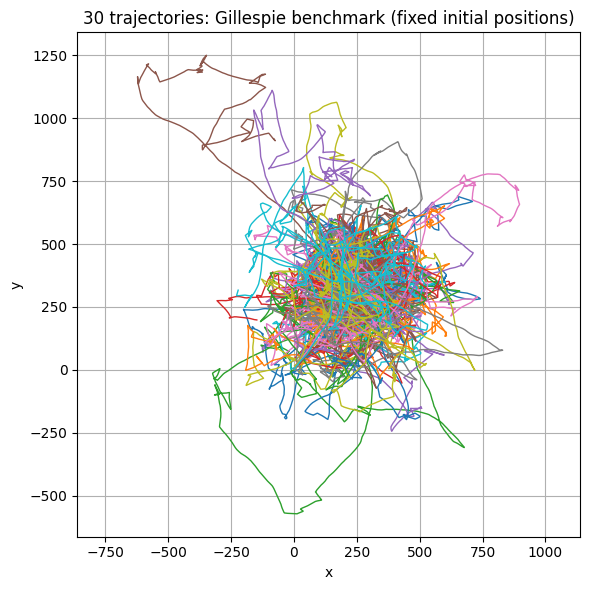

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(N):
    g_dfi = df_gill[df_gill.run_id == i]
    plt.plot(g_dfi.x.values, g_dfi.y.values, linewidth=1.0)
plt.scatter([light_xy[0]], [light_xy[1]])
plt.title("30 trajectories: Gillespie benchmark (fixed initial positions)")
plt.xlabel("x"); plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.savefig("./fig_trajectories_gillespie.png", dpi=160)
plt.show()

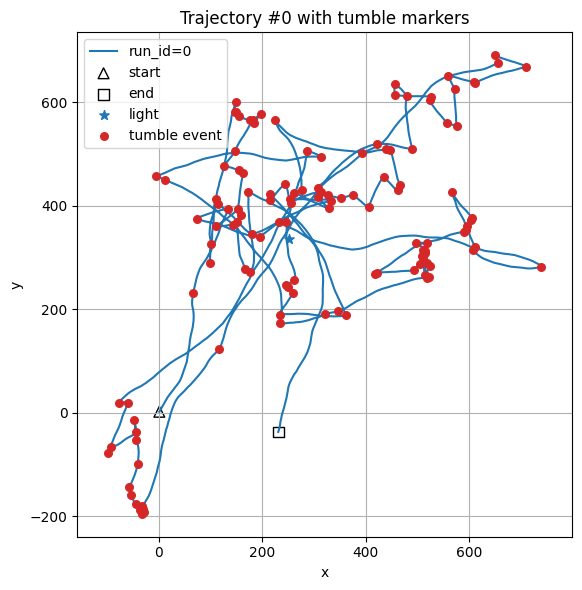

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_trajectory_with_tumbles(df, run_id=0, light_xy=None,
                                 order_col=None, savepath=None,
                                 mark_all_tumble_steps=False):
    """
    画指定 run_id 的单条轨迹，并标出 tumble 位置。
    参数：
      df: 含列 run_id, x, y 以及 action(或 event)；可选 t 或 step
      run_id: 要绘制的轨迹编号
      light_xy: 光源坐标 (x,y)，可为 None
      order_col: 排序列名，优先用 't'，否则用 'step'；可手动指定
      savepath: 保存路径（如 'fig_one_trajectory.png'）；None 则不保存
      mark_all_tumble_steps: 若为 True 且使用 action，则对所有 action==1 的步打点；
                             否则只标 run→tumble 的切换时刻（推荐）
    """
    g = df[df.run_id == run_id].copy()
    if g.empty:
        raise ValueError(f"run_id={run_id} 在 df 中不存在。")

    # 选择排序列
    if order_col is None:
        if 't' in g.columns: order_col = 't'
        elif 'step' in g.columns: order_col = 'step'
        else: order_col = None
    if order_col is not None:
        g = g.sort_values(order_col)

    fig, ax = plt.subplots(figsize=(6, 6))

    # 轨迹曲线
    ax.plot(g.x.values, g.y.values, lw=1.5, label=f'run_id={run_id}')

    # 起点/终点
    ax.scatter([g.x.values[0]], [g.y.values[0]], s=60, marker='^', edgecolors='k', facecolors='none', label='start')
    ax.scatter([g.x.values[-1]], [g.y.values[-1]], s=60, marker='s', edgecolors='k', facecolors='none', label='end')

    # 光源
    if light_xy is not None:
        ax.scatter([light_xy[0]], [light_xy[1]], s=50, marker='*', zorder=5, label='light')

    # 事件/切换检测
    tumble_mask = None
    label_used = False

    if 'event' in g.columns:
        # 瞬时 tumble：直接用 event==1 的点
        tumble_mask = (g['event'] == 1)
        tx, ty = g.loc[tumble_mask, 'x'].values, g.loc[tumble_mask, 'y'].values
        if tx.size:
            ax.scatter(tx, ty, s=30, c='C3', marker='o', zorder=6, label='tumble event')
            label_used = True

    elif 'action' in g.columns:
        if mark_all_tumble_steps:
            # 对所有 tumble 步打点（可能很多）
            tumble_mask = (g['action'] == 1)
        else:
            # 只标记 run->tumble 的切换时刻（推荐）
            a = g['action'].to_numpy()
            prev = np.roll(a, 1); prev[0] = a[0]  # 第一行没有前驱，保持一致
            tumble_mask = (a == 1) & (prev == 0)

        tx, ty = g.loc[tumble_mask, 'x'].values, g.loc[tumble_mask, 'y'].values
        if tx.size:
            ax.scatter(tx, ty, s=30, c='C3', marker='o', zorder=6, label='tumble' if not label_used else None)
            label_used = True

    else:
        print("警告：未发现 'event' 或 'action' 列，无法标记 tumble。")

    ax.set_title(f"Trajectory #{run_id} with tumble markers")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.axis("equal"); ax.grid(True)
    ax.legend(loc='best')
    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=160)
    plt.show()


plot_trajectory_with_tumbles(df_gill, run_id=0, light_xy=light_xy, mark_all_tumble_steps=True)


In [ ]:
sum_gil= df_gill.groupby('run_id').apply(
    lambda g: pd.Series(dict(
        method='gillespie',
        step_ratio=float((g['event']==1).mean()),
        total=len(g), # Corrected to get the total number of rows in the group
        # time_ratio=float((g['event']*g['dt']).sum()/g['dt'].sum())
    ))
).reset_index()

/tmp/ipython-input-3193252504.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sum_gil= df_gill.groupby('run_id').apply(


tumbling ratio comparison

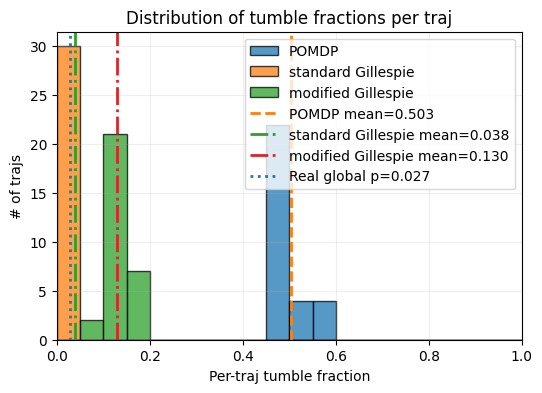

In [ ]:
vals_p= sum_pol['step_ratio'].dropna().to_numpy()
vals_g = sum_gil["step_ratio"].dropna().to_numpy()

bins = np.linspace(0, 1, 21)
p_sim=vals_p.mean()
p_g=vals_g.mean()
p_real=per_cell["tumble_frac"].mean()
plt.figure(figsize=(6,4))
plt.hist(vals_p, bins=bins, alpha=0.75, edgecolor="k",label="POMDP")
plt.hist(vals_g, bins=bins, alpha=0.75, edgecolor="k",label="standard Gillespie")
plt.hist(vals_gm, bins=bins, alpha=0.75, edgecolor="k",label="modified Gillespie")

plt.axvline(p_sim, color="C1", ls="--", lw=2, label=f"POMDP mean={p_sim:.3f}")
plt.axvline(p_g, color="C2", ls="-.",  lw=2, label=f"standard Gillespie mean={p_g:.3f}")
plt.axvline(p_gm, color="C3", ls="-.",  lw=2, label=f"modified Gillespie mean={p_gm:.3f}")
plt.axvline(p_real, color="C0", ls=":",  lw=2, label=f"Real global p={p_real:.3f}")
plt.xlabel("Per-traj tumble fraction")
plt.ylabel("# of trajs")
plt.title("Distribution of tumble fractions per traj")
plt.legend()
plt.xlim(0,1)
plt.grid(alpha=0.2)
plt.show()

/tmp/ipython-input-3387512549.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('run_id', as_index=False, group_keys=False).apply(_diff_vel)
/tmp/ipython-input-3387512549.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('run_id', as_index=False, group_keys=False).apply(_diff_vel)


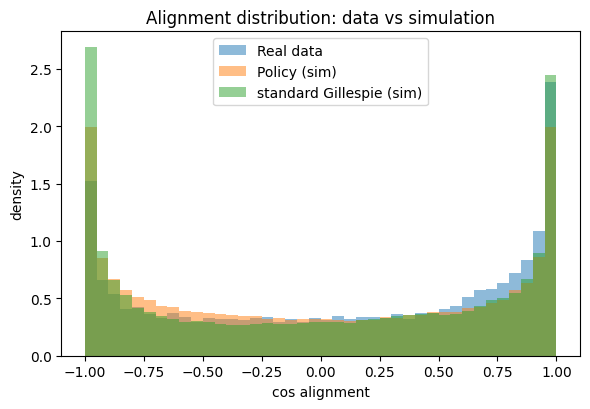

In [ ]:
# === 加载数据 ===
df_policy = pd.read_csv("./trajs_policy.csv")          # run_id, step, x, y, action, dt
df_gill   = pd.read_csv("./trajs_gillespie.csv")       # run_id, t(or step), x, y, action, dt

mu = light_xy  # ←← 填入你的光源坐标

# === 计算 alignment ===
cos_policy = alignment_from_df(df_policy, mu)
cos_gill   = alignment_from_df(df_gill,   mu)
# cos_data   = alignment_from_df(df_data,   mu, vx_col='vx', vy_col='vy')

# === 画直方图（叠加）===
plt.figure(figsize=(6,4.2))
plt.hist(data_cos,   bins=40, density=True, alpha=0.5, label='Real data')
plt.hist(cos_policy, bins=40, density=True, alpha=0.5, label='Policy (sim)')
plt.hist(cos_gill,   bins=40, density=True, alpha=0.5, label='standard Gillespie (sim)')
plt.xlabel('cos alignment'); plt.ylabel('density')
plt.title('Alignment distribution: data vs simulation')
plt.legend(); plt.tight_layout(); plt.show()


n_data              1.200000e+05
n_sim               1.199700e+05
KS_D                3.868291e-02
KS_p                1.953758e-78
W1                  4.256917e-02
JS                  3.632158e-03
hist_L1             1.363014e-01
E_cos_data         -3.567164e-03
E_cos_sim           1.164096e-02
P(cos>0.8)_data     2.030667e-01
P(cos>0.8)_sim      2.279653e-01
P(cos<-0.8)_data    2.041750e-01
P(cos<-0.8)_sim     2.396182e-01
dtype: float64

CIs (bootstrap 95%):
KS_D   in [0.036, 0.042]
W1     in [0.039, 0.046]
JS     in [0.003, 0.004]
hist_L1 in [0.130, 0.146]


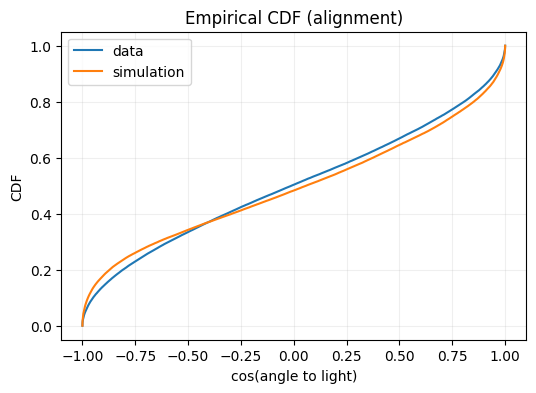

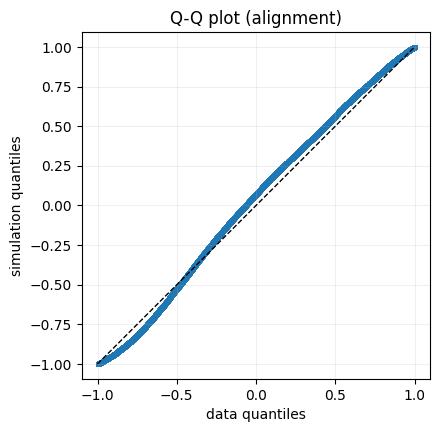

In [ ]:
res = summarize_alignment(cos_gill, cos_policy,bins=40)
ks_ci = bootstrap_ci(lambda a,b: ks_2samp(a,b).statistic, cos_gill, cos_policy)
w1_ci = bootstrap_ci(lambda a,b: wasserstein_distance(a,b), cos_gill, cos_policy)
js_ci = bootstrap_ci(lambda a,b: js_divergence(a,b, bins=40), cos_gill, cos_policy)
l1_ci = bootstrap_ci(lambda a,b: hist_L1(a,b, bins=40), cos_gill, cos_policy)

print(pd.Series(res))
print("\nCIs (bootstrap 95%):")
print(f"KS_D   in [{ks_ci[0]:.3f}, {ks_ci[1]:.3f}]")
print(f"W1     in [{w1_ci[0]:.3f}, {w1_ci[1]:.3f}]")
print(f"JS     in [{js_ci[0]:.3f}, {js_ci[1]:.3f}]")
print(f"hist_L1 in [{l1_ci[0]:.3f}, {l1_ci[1]:.3f}]")
plot_cdf_compare(cos_policy, cos_gill)
plot_qq_compare(cos_policy, cos_gill)

Pairwise distances (lower = closer):



,KS,KS_p,W1,JS,hist_L1
pair,,,,,
Policy vs Gillespie,0.0387,0.0000,0.0426,0.0036,0.1363
Real vs Gillespie,0.0855,0.0000,0.1145,0.0072,0.1797
Real vs Policy,0.0825,0.0000,0.1290,0.0047,0.1731



95% bootstrap CI:
- Real vs Policy: KS[0.077,0.091]  W1[0.119,0.140]  JS[0.0043,0.0058]  L1[0.163,0.191]
- Real vs Gillespie: KS[0.080,0.092]  W1[0.104,0.125]  JS[0.0066,0.0084]  L1[0.173,0.198]
- Policy vs Gillespie: KS[0.036,0.042]  W1[0.039,0.046]  JS[0.0034,0.0041]  L1[0.131,0.146]


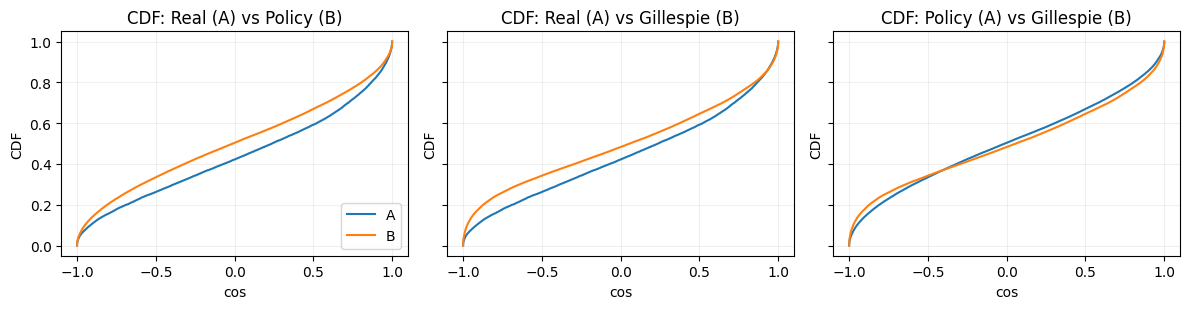

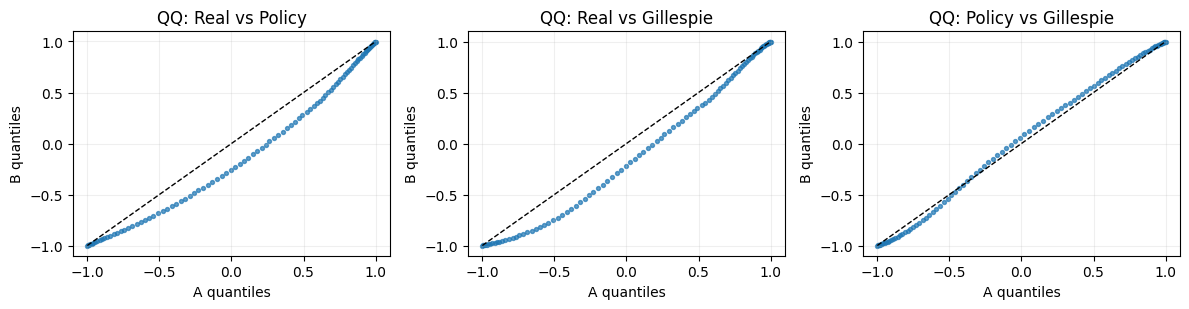

In [ ]:
def summarize_(real, policy, gill, bins=40, B=1000):
    pairs = {
        "Real vs Policy"   : (real, policy),
        "Real vs Gillespie": (real, gill),
        "Policy vs Gillespie": (policy, gill),
    }
    rows = []
    cis  = {}
    for name, (x, y) in pairs.items():
        ks  = ks_2samp(x, y)
        w1  = wasserstein_distance(x, y)
        js  = js_divergence(x, y, bins=bins)
        l1  = hist_L1(x, y, bins=bins)
        ks_ci = bootstrap_ci(lambda a,b: ks_2samp(a,b).statistic, x, y, B=B)
        w1_ci = bootstrap_ci(lambda a,b: wasserstein_distance(a,b), x, y, B=B)
        js_ci = bootstrap_ci(lambda a,b: js_divergence(a,b, bins=bins), x, y, B=B)
        l1_ci = bootstrap_ci(lambda a,b: hist_L1(a,b, bins=bins), x, y, B=B)
        rows.append(dict(pair=name, KS=ks.statistic, KS_p=ks.pvalue, W1=w1, JS=js, hist_L1=l1))
        cis[name] = dict(KS=ks_ci, W1=w1_ci, JS=js_ci, hist_L1=l1_ci)
    df = pd.DataFrame(rows).set_index("pair").sort_index()
    return df, cis

# ==== 画图：直方图叠加 + CDF + QQ（1x3 对三对）====

def _ecdf(x):
    x = np.asarray(x, float)
    x = x[~np.isnan(x)]
    xs = np.sort(x)
    n  = len(xs)
    if n == 0:
        return np.array([0.0]), np.array([0.0])
    Fs = np.arange(1, n+1, dtype=float)/n
    return xs, Fs
def _plot_cdf_pair(ax, a, b, title):
    xa, Fa = _ecdf(a); xb, Fb = _ecdf(b)
    ax.plot(xa, Fa, label="A")
    ax.plot(xb, Fb, label="B")
    ax.set_title(title); ax.set_xlabel("cos"); ax.set_ylabel("CDF"); ax.grid(alpha=0.2)

def _plot_qq_pair(ax, a, b, title):
    qs = np.linspace(0.01, 0.99, 99)
    qa = np.quantile(a, qs); qb = np.quantile(b, qs)
    ax.scatter(qa, qb, s=8, alpha=0.7)
    lo = min(qa.min(), qb.min()); hi = max(qa.max(), qb.max())
    ax.plot([lo,hi],[lo,hi], 'k--', lw=1)
    ax.set_title(title); ax.set_xlabel("A quantiles"); ax.set_ylabel("B quantiles"); ax.grid(alpha=0.2)

def plot_cdf_three(real, policy, gill):
    fig, axes = plt.subplots(1,3, figsize=(12,3.2), sharey=True)
    _plot_cdf_pair(axes[0], real, policy,   "CDF: Real (A) vs Policy (B)")
    _plot_cdf_pair(axes[1], real, gill,     "CDF: Real (A) vs Gillespie (B)")
    _plot_cdf_pair(axes[2], policy, gill,   "CDF: Policy (A) vs Gillespie (B)")
    axes[0].legend(loc="lower right")
    plt.tight_layout(); plt.show()

def plot_qq_three(real, policy, gill):
    fig, axes = plt.subplots(1,3, figsize=(12,3.2), sharex=False, sharey=False)
    _plot_qq_pair(axes[0], real, policy,   "QQ: Real vs Policy")
    _plot_qq_pair(axes[1], real, gill,     "QQ: Real vs Gillespie")
    _plot_qq_pair(axes[2], policy, gill,   "QQ: Policy vs Gillespie")
    plt.tight_layout(); plt.show()

# ==== 一键运行（把你的数组名替换进去）====


bins = 40
df_metrics, cis = summarize_(data_cos, cos_policy, cos_gill, bins=bins, B=800)
print("Pairwise distances (lower = closer):\n")
display(df_metrics.style.format("{:.4f}"))

print("\n95% bootstrap CI:")
for pair, d in cis.items():
    print(f"- {pair}: "
          f"KS[{d['KS'][0]:.3f},{d['KS'][1]:.3f}]  "
          f"W1[{d['W1'][0]:.3f},{d['W1'][1]:.3f}]  "
          f"JS[{d['JS'][0]:.4f},{d['JS'][1]:.4f}]  "
          f"L1[{d['hist_L1'][0]:.3f},{d['hist_L1'][1]:.3f}]")

plot_cdf_three(data_cos, cos_policy, cos_gill)
plot_qq_three(data_cos, cos_policy, cos_gill)

整理一下代码，加上正确的数学公式和说明

### 校准 τ
do a hyperparam search on temperature τbecause it affects the tumble ratio

In [ ]:
import numpy as np, torch

@torch.no_grad()
def _sim_tumble_ratio_once(env, r_star, tau, kin, steps, dt, seed, x0=None, random=False):
    """单次仿真，返回该次 tumble 比率（按步计数）。"""
    policy_fn = policy_from_reward(r_star, env.TT, env.ZZ, tau=float(tau), curiosity=0.0)
    traj, acts, bels, vlist = simulate_pomdp(
        env, policy_fn, kin, steps=steps, dt=dt, seed=seed, x0=x0, random=random
    )
    return float((acts == 1).mean()) if acts.size > 0 else np.nan


@torch.no_grad()
def eval_tau_by_sim(env, r_star, tau, kin, steps=800, dt=0.125,
                    n_runs=8, base_seed=0, random_init=False, x0=None):
    """给定 tau，多次仿真取平均与标准差。"""
    ratios = []
    for k in range(n_runs):
        seed = int(base_seed + k)
        r = _sim_tumble_ratio_once(
            env, r_star, tau, kin, steps=steps, dt=dt,
            seed=seed, x0=x0, random=random_init
        )
        ratios.append(r)
    ratios = np.asarray(ratios, float)
    return float(np.nanmean(ratios)), float(np.nanstd(ratios))


In [ ]:
@torch.no_grad()
def calibrate_tau_by_sim(env, r_star, kin,
                         target_ratio,
                         steps=800, dt=0.125,
                         # 粗扫设置
                         coarse_range=(1e-3, 2.0), coarse_points=25, coarse_log=True,
                         # 细扫设置（对数区间逐次缩小）
                         refine_iters=3, grid_each=21, span0=5.0, shrink=3.0,
                         # 多次仿真平均
                         n_runs=8, base_seed=0, random_init=False, x0=None,
                         verbose=True):
    """
    按“你的仿真循环”标定 tau，使仿真 tumble 比率 ~ target_ratio。
    - 粗扫：在给定区间对数/线性取点
    - 若最佳点落在边界，先做一次‘扩边’
    - 多轮细扫：以最佳点为中心做 log-space 网格，并逐轮缩窄
    返回：tau_best, table(list of dict)
    """
    lo, hi = map(float, coarse_range)
    if coarse_log:
        taus0 = np.exp(np.linspace(np.log(lo), np.log(hi), int(coarse_points)))
    else:
        taus0 = np.linspace(lo, hi, int(coarse_points))
    table = []

    def _push_result(tau, mean_ratio, std_ratio):
        table.append(dict(tau=float(tau),
                          ratio=float(mean_ratio),
                          ratio_std=float(std_ratio),
                          err=float(abs(mean_ratio - target_ratio))))

    # ---- 粗扫 ----
    if verbose:
        print(f"[τ-calib] target_ratio = {target_ratio:.4f}")
        print(f"[coarse] range=({lo:.3g},{hi:.3g}) points={len(taus0)} log={coarse_log}")
    for tau in taus0:
        m, s = eval_tau_by_sim(env, r_star, tau, kin, steps=steps, dt=dt,
                               n_runs=n_runs, base_seed=base_seed,
                               random_init=random_init, x0=x0)
        _push_result(tau, m, s)
        if verbose:
            print(f"  tau={tau:8.5f}  ratio={m:.4f}±{s:.4f}  |err|={abs(m-target_ratio):.4f}")

    table.sort(key=lambda d: d["err"])
    tau_best = table[0]["tau"]
    if verbose:
        print(f"[coarse] best tau={tau_best:.6f}  ratio={table[0]['ratio']:.4f}  |err|={table[0]['err']:.4f}")

    # 若最佳点在边界，做一次‘扩边’（避免老是卡在 lower/upper）
    at_lower = np.isclose(tau_best, np.min(taus0))
    at_upper = np.isclose(tau_best, np.max(taus0))
    if at_lower or at_upper:
        if verbose:
            side = "LOWER" if at_lower else "UPPER"
            print(f"[expand] best at {side} boundary, expanding search range...")
        if at_lower:
            lo2, hi2 = tau_best/10.0, tau_best*span0
        else:
            lo2, hi2 = tau_best/span0, tau_best*10.0
        taus_exp = np.exp(np.linspace(np.log(max(lo2,1e-6)), np.log(hi2), grid_each))
        for tau in taus_exp:
            m, s = eval_tau_by_sim(env, r_star, tau, kin, steps=steps, dt=dt,
                                   n_runs=n_runs, base_seed=base_seed+999,
                                   random_init=random_init, x0=x0)
            _push_result(tau, m, s)
            if verbose:
                print(f"  tau={tau:8.5f}  ratio={m:.4f}±{s:.4f}  |err|={abs(m-target_ratio):.4f}")
        table.sort(key=lambda d: d["err"])
        tau_best = table[0]["tau"]
        if verbose:
            print(f"[expand] best tau={tau_best:.6f}  ratio={table[0]['ratio']:.4f}  |err|={table[0]['err']:.4f}")

    # ---- 多轮细扫（对数区间）----
    span = float(span0)
    for it in range(refine_iters):
        lo_i = max(1e-6, tau_best / span)
        hi_i = tau_best * span
        taus_i = np.exp(np.linspace(np.log(lo_i), np.log(hi_i), grid_each))
        if verbose:
            print(f"[refine {it+1}/{refine_iters}] around {tau_best:.6f}, "
                  f"log-range=({lo_i:.6f},{hi_i:.6f}), grid={grid_each}")
        for tau in taus_i:
            m, s = eval_tau_by_sim(env, r_star, tau, kin, steps=steps, dt=dt,
                                   n_runs=n_runs, base_seed=base_seed+1000*(it+1),
                                   random_init=random_init, x0=x0)
            _push_result(tau, m, s)
            if verbose:
                print(f"  tau={tau:8.6f}  ratio={m:.4f}±{s:.4f}  |err|={abs(m-target_ratio):.4f}")
        table.sort(key=lambda d: d["err"])
        tau_best = table[0]["tau"]
        if verbose:
            print(f"[refine {it+1}] best tau={tau_best:.6f}  ratio={table[0]['ratio']:.4f}  |err|={table[0]['err']:.4f}")
        span = max(1.5, span / float(shrink))  # 逐轮收窄，对数尺度

    return tau_best, table


In [ ]:
# 真实（目标）tumble ratio（统一 dt 后建议用步数占比；若用原始不等间隔流，可用时间加权）
# def estimate_target_ratio_from_samples(samples, time_weight=False):
#     a = np.array([s["a"] for s in samples], float)   # 需要 samples 里有 a∈{0,1}
#     if time_weight:
#         w = np.array([s["dt"] for s in samples], float)
#         w = w / (w.sum() + 1e-12)
#         return float((w * a).sum())
#     return float((a==1).mean())

target_ratio = p_real
 # 或者用你想要的常数


tau_best, table = calibrate_tau_by_sim(
    env=env_new, r_star=r_star, kin=kin_sim,
    target_ratio=target_ratio,
    steps=800, dt=0.125,
    coarse_range=(1e-3, 2.0), coarse_points=25, coarse_log=True,
    refine_iters=3, grid_each=21, span0=3.0, shrink=3.0,
    n_runs=8, base_seed=0, random_init=False, x0=None,
    verbose=True
)

print("\n==> tau_best =", tau_best)
# 你也可以把 table 转成 DataFrame 画出 ratio vs tau 曲线
import pandas as pd
df_tau = pd.DataFrame(table).sort_values("tau").reset_index(drop=True)
display(df_tau.head())


[τ-calib] target_ratio = 0.0273
[coarse] range=(0.001,2) points=25 log=True
  tau= 0.00100  ratio=0.0098±0.0052  |err|=0.0174
  tau= 0.00137  ratio=0.0098±0.0052  |err|=0.0174
  tau= 0.00188  ratio=0.0098±0.0052  |err|=0.0174
  tau= 0.00259  ratio=0.0098±0.0052  |err|=0.0174
  tau= 0.00355  ratio=0.0097±0.0054  |err|=0.0176
  tau= 0.00487  ratio=0.0097±0.0054  |err|=0.0176
  tau= 0.00669  ratio=0.0103±0.0050  |err|=0.0170
  tau= 0.00918  ratio=0.0169±0.0055  |err|=0.0104
  tau= 0.01260  ratio=0.0350±0.0095  |err|=0.0077
  tau= 0.01729  ratio=0.0658±0.0123  |err|=0.0385
  tau= 0.02374  ratio=0.1253±0.0159  |err|=0.0980
  tau= 0.03258  ratio=0.1958±0.0187  |err|=0.1685
  tau= 0.04472  ratio=0.4948±0.3139  |err|=0.4676
  tau= 0.06138  ratio=0.3158±0.0290  |err|=0.2885
  tau= 0.08426  ratio=0.4255±0.1670  |err|=0.3982
  tau= 0.11565  ratio=0.4044±0.0170  |err|=0.3771
  tau= 0.15874  ratio=0.4594±0.0974  |err|=0.4321
  tau= 0.21789  ratio=0.4639±0.0726  |err|=0.4366
  tau= 0.29907  ratio=0.

,tau,ratio,ratio_std,err
0,0.001000,0.009844,0.005208,0.017431
1,0.001373,0.009844,0.005208,0.017431
2,0.001884,0.009844,0.005208,0.017431
3,0.002586,0.009844,0.005208,0.017431
4,0.003550,0.009688,0.005367,0.017587


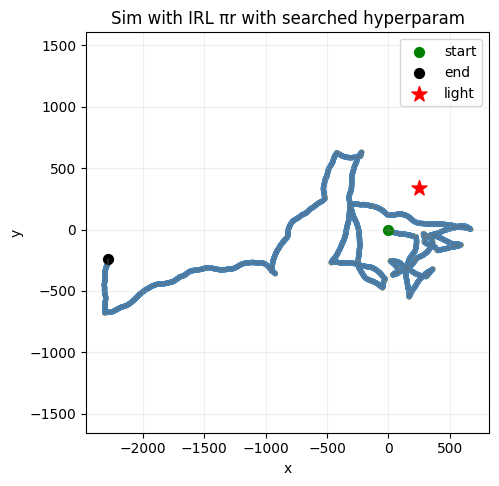

In [ ]:
pi_r_b = policy_from_reward(r_star, env_new.TT, env_new.ZZ, tau=tau_best, curiosity=0.0)
traj_b, acts_b, bels_b, vlist_b= simulate_pomdp(env_new, pi_r_b, kin_sim, steps=4000, dt=dt_policy, seed=0)
plot_trajectory(traj_b, acts_b, src_mu=env_new.src["mu"], title="Sim with IRL πr with searched hyperparam")

generate 30 traj with new policy(searched param)

##
simulate more trajs(30) with learned policy

In [ ]:

N=30
policy_trajs_b=[]
for i in range(N):
  traj_b, acts_b, bels_b, vlist_b= simulate_pomdp(env_new, pi_r_b, kin_sim, random=False,steps=4000, dt=dt_policy, seed=1000+i)
  run_id_b = np.full(len(traj_b), i, int)
  step_id_b = np.arange(len(traj_b))
  acts_b=[0]+acts_b.tolist()

  df_one_b = pd.DataFrame(dict(run_id=run_id_b, step=step_id_b, x=traj_b[:, 0], y=traj_b[:, 1], action=acts_b,dt=dt_policy))
  policy_trajs_b.append(df_one_b)

df_policy_b = pd.concat(policy_trajs_b, ignore_index=True)
df_policy_b.to_csv("./trajs_policy_searched_param.csv", index=False)

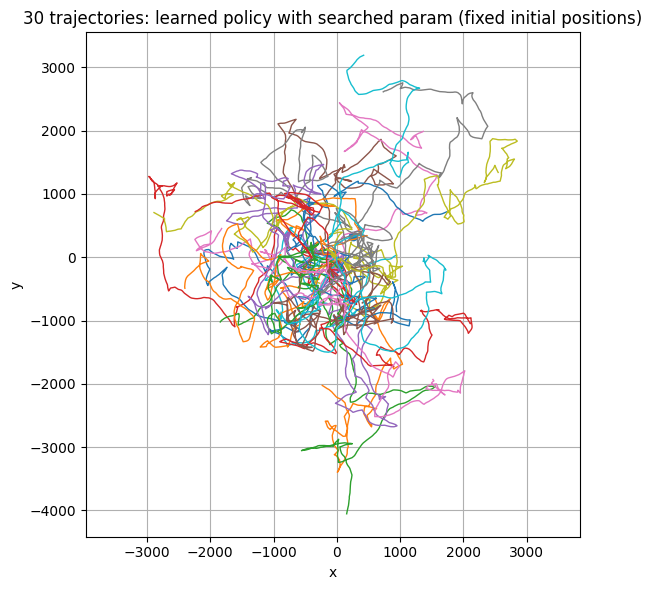

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(N):
    dfi_b = df_policy_b[df_policy_b.run_id == i]
    plt.plot(dfi_b.x.values, dfi_b.y.values, linewidth=1.0)
plt.scatter([light_xy[0]], [light_xy[1]])
plt.title("30 trajectories: learned policy with searched param (fixed initial positions)")
plt.xlabel("x"); plt.ylabel("y")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.savefig("./fig_trajectories_policy_searched_param.png", dpi=160)
plt.show()

In [ ]:
import pandas as pd
from IPython.display import display # Import display


sum_pol_b = df_policy_b.groupby('run_id').apply(
    lambda g: pd.Series(dict(
        method='policy with searched param',
        step_ratio=float((g['action']==1).mean()),
        time_ratio=float((g['action']*g['dt']).sum()/g['dt'].sum())
    ))
).reset_index()

# display(sum_pol) # Use the imported display function

/tmp/ipython-input-1709452530.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sum_pol_b = df_policy_b.groupby('run_id').apply(


comparison with Gillespie

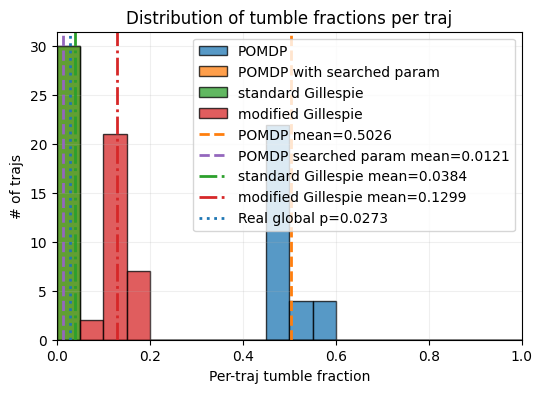

In [ ]:
vals_p_b= sum_pol_b['step_ratio'].dropna().to_numpy()

bins = np.linspace(0, 1, 21)
p_sim_b=vals_p_b.mean()

plt.figure(figsize=(6,4))
plt.hist(vals_p, bins=bins, alpha=0.75, edgecolor="k",label="POMDP")
plt.hist(vals_p_b, bins=bins, alpha=0.75, edgecolor="k",label="POMDP with searched param")
plt.hist(vals_g, bins=bins, alpha=0.75, edgecolor="k",label="standard Gillespie ")
plt.hist(vals_gm, bins=bins, alpha=0.75, edgecolor="k",label="modified Gillespie ")

plt.axvline(p_sim, color="C1", ls="--", lw=2, label=f"POMDP mean={p_sim:.4f}")
plt.axvline(p_sim_b, color="C4", ls="--", lw=2, label=f"POMDP searched param mean={p_sim_b:.4f}")
plt.axvline(p_g, color="C2", ls="-.",  lw=2, label=f"standard Gillespie mean={p_g:.4f}")
plt.axvline(p_gm, color="C3", ls="-.",  lw=2, label=f"modified Gillespie mean={p_gm:.4f}")
plt.axvline(p_real, color="C0", ls=":",  lw=2, label=f"Real global p={p_real:.4f}")
plt.xlabel("Per-traj tumble fraction")
plt.ylabel("# of trajs")
plt.title("Distribution of tumble fractions per traj")
plt.legend()
plt.xlim(0,1)
plt.grid(alpha=0.2)
plt.show()

/tmp/ipython-input-3387512549.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('run_id', as_index=False, group_keys=False).apply(_diff_vel)


Pairwise distances (lower = closer):



,KS,KS_p,W1,JS,hist_L1
pair,,,,,
Policy vs Gillespie,0.1195,0.0000,0.1645,0.0108,0.2503
Real vs Gillespie,0.0855,0.0000,0.1145,0.0072,0.1797
Real vs Policy,0.1828,0.0000,0.2774,0.0200,0.3643



95% bootstrap CI:
- Real vs Policy: KS[0.176,0.190]  W1[0.267,0.287]  JS[0.0188,0.0217]  L1[0.350,0.379]
- Real vs Gillespie: KS[0.080,0.092]  W1[0.104,0.125]  JS[0.0066,0.0084]  L1[0.173,0.198]
- Policy vs Gillespie: KS[0.116,0.124]  W1[0.159,0.170]  JS[0.0103,0.0115]  L1[0.243,0.259]


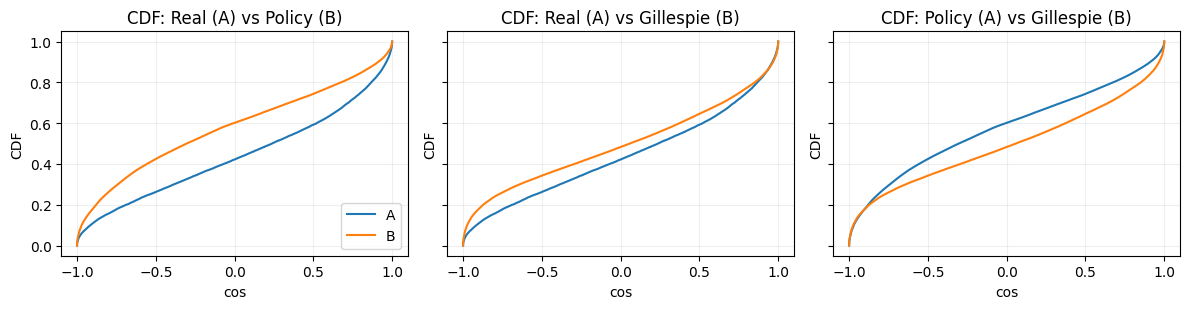

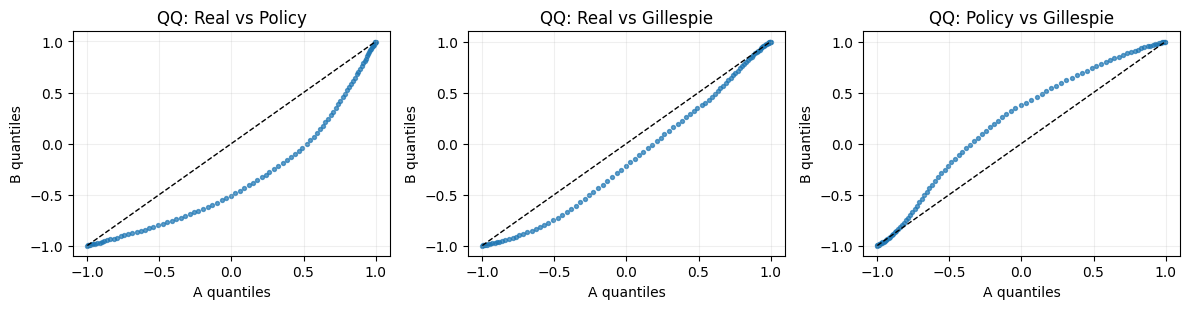

In [ ]:
bins = 40
data_cos_b= alignment_from_df(df_policy_b, mu)
df_metrics_b, cis_b = summarize_(data_cos, data_cos_b, cos_gill, bins=bins, B=800)
print("Pairwise distances (lower = closer):\n")
display(df_metrics_b.style.format("{:.4f}"))

print("\n95% bootstrap CI:")
for pair, d in cis_b.items():
    print(f"- {pair}: "
          f"KS[{d['KS'][0]:.3f},{d['KS'][1]:.3f}]  "
          f"W1[{d['W1'][0]:.3f},{d['W1'][1]:.3f}]  "
          f"JS[{d['JS'][0]:.4f},{d['JS'][1]:.4f}]  "
          f"L1[{d['hist_L1'][0]:.3f},{d['hist_L1'][1]:.3f}]")

plot_cdf_three(data_cos, data_cos_b, cos_gill)
plot_qq_three(data_cos, data_cos_b, cos_gill)